## MERCARI PRICE SUGGESTION CHALLENGE MODELS

#### MODELS:-

These are the following models which we would try on the final preprocessed data of Mercari Price Suggestion Challenge data.

1) XGBoost Regressor.

2) Random Forest Regressor.

3) Ridge Regression (SGDRegressor with L2 penalty)

4) Decision Tree (Decision Tree Regressor)

5) Adaboost (Adaboost Regressor)

The error metric on which these models would be assessed is <b> RMSLE i.e. Root Mean Squared Logarithmic Error </b>.

The approach would be to check the RMSLE on the random model i.e. the RMSLE on the average logarithmic price and then to choose the model which gives the best performance on the test data i.e. the lowest <b> RMSLE </b> or <b> Root Mean Squared Logarithmic Error </b>.

#### FEATURES:-

1) Label Encoded Item_Condition_Id

2) Shipping

3) Label Encoded General_cat

4) Label Encoded subcat_1

5) Label Encoded subcat_2

6) Item_Description Length

7) Concatenation of Label Encoded Brand Name, Tfidf Vectorized Preprocessed Item Description and Label Encoded product_category.

8) Sentiment Score neg

9) Sentiment Score pos

8) Sentiment Score neu

9) Sentiment Score compound

#### RESPONSE:-

1) log_price.

#### RANDOM MODEL:-

RMSLE of the training data on the average log_price.

### DATA IMPORT

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import hstack
from sklearn.metrics import mean_squared_log_error as msle
#from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Self_Case_Study_1"

In [4]:
mercari_pricedata_fin = pd.read_csv(path + "/mercari_pricedata_product_category.csv")

In [5]:
# Checking the first five rows of the data

mercari_pricedata_fin.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,product_category
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,1,description yet,0.0,1.000,0.000,0.0000,cheap
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,14,keyboard great condition works like came box p...,0.0,0.565,0.435,0.8957,expensive
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,10,adorable top hint lace key hole back pale pink...,0.0,0.667,0.333,0.6124,cheap
3,3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,No Brand Name,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,14,new tags leather horses retail stand foot high...,0.0,0.728,0.272,0.6808,expensive
4,4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,No Brand Name,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,3,complete certificate authenticity,0.0,1.000,0.000,0.0000,expensive


### TRAIN TEST SPLIT

In [6]:
#Getting the dataframes of the features and response

X = mercari_pricedata_fin.drop(["Unnamed: 0","train_id","name","category_name","log_price","item_description","product_category"], axis=1)
Y = mercari_pricedata_fin["price"]
#Y_log = mercari_pricedata_fin["log_price"]

In [7]:
#Checking the first five rows of the features dataframe X

X.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
0,3,MLB,10.0,1,Men,Tops,T-shirts,1,description yet,0.0,1.000,0.000,0.0000
1,3,Razer,52.0,0,Electronics,Computers & Tablets,Components & Parts,14,keyboard great condition works like came box p...,0.0,0.565,0.435,0.8957
2,1,Target,10.0,1,Women,Tops & Blouses,Blouse,10,adorable top hint lace key hole back pale pink...,0.0,0.667,0.333,0.6124
3,1,No Brand Name,35.0,1,Home,Home Décor,Home Décor Accents,14,new tags leather horses retail stand foot high...,0.0,0.728,0.272,0.6808
4,1,No Brand Name,44.0,0,Women,Jewelry,Necklaces,3,complete certificate authenticity,0.0,1.000,0.000,0.0000


In [8]:
# Splitting the data into train and test on the original price variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

In [9]:
# Checking the first five rows of X_train
X_train.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
204717,1,Nike,12.0,0,Kids,Boys 0-24 Mos,Accessories,10,new tags nike socks months crawler socks top g...,0.00,0.859,0.141,0.2023
231882,3,Nerf,20.0,0,Sports & Outdoors,Outdoors,Indoor,3,one drum mag round mags,0.00,1.000,0.000,0.0000
1274186,1,PINK,9.0,0,Women,Underwear,Panties,6,free ship price firm bundle okay,0.00,0.435,0.565,0.6369
269654,1,Victoria's Secret,20.0,0,Women,Athletic Apparel,"Pants, Tights, Leggings",6,nwt paid love pregnant gonna fit right,0.00,0.427,0.573,0.7717
1008253,2,Pokemon,3.0,1,Vintage & Collectibles,Trading Cards,Animation,64,seel reverse holo sleeve mint weedle reverse h...,0.08,0.836,0.085,0.1027


In [10]:
# Checking the first five rows of X_test
X_test.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
777341,1,No Brand Name,12.0,1,Handmade,Paper Goods,Stationery,17,listing totoro washi tape limited time offer a...,0.095,0.905,0.000,-0.2263
1463629,1,Adidas,76.0,1,Women,Other,Other,1,items,0.000,1.000,0.000,0.0000
350669,1,No Brand Name,12.0,1,Beauty,Makeup,Lips,2,sunglasses necklace,0.000,1.000,0.000,0.0000
310222,1,No Brand Name,3.0,1,Kids,Toys,Arts & Crafts,7,ordered bunch stickers recieve many cute ones,0.000,0.667,0.333,0.4588
759257,2,Chanel,30.0,1,Beauty,Makeup,Lips,7,brand new never used authentic mini lipgloss g...,0.000,0.734,0.266,0.4404


In [11]:
# Checking the shape of the training data
X_train.shape

(1111901, 13)

In [12]:
# Checking the shape of the test data
X_test.shape

(370634, 13)

#### MARKING THE BRAND CATEGORY AND REMOVING THE PRODUCT CATEGORY

In [13]:
# Getting the average price per brand in the training set

brand_avgprice = X_train[["brand_name","price"]].groupby(X_train["brand_name"]).mean()

brand_avgprice

,price
brand_name,
!iT Jeans,16.000000
% Pure,16.400000
10.Deep,17.333333
191 Unlimited,36.000000
1byone,51.000000
...,...
tokidoki,31.829167
totes ISOTONER,16.565217
triangl swimwear,32.666667


In [14]:
brand_avgprice = brand_avgprice.sort_values(by = ["price"], ascending = False)

brand_avgprice

,price
brand_name,
Proenza Schouler,435.666667
Demdaco,431.500000
Oris,300.000000
MCM Worldwide,277.886792
Rick Owens,259.000000
...,...
Old Glory,3.000000
Twilight Gypsy Collective,3.000000
Archie Comics,3.000000


In [15]:
# Checking the quantile of prices in the training set

first_quantile_price = np.percentile(X_train.price.values, 25)
third_quantile_price = np.percentile(X_train.price.values, 75)

print("The 25th percentile of price for the products is : {}".format(first_quantile_price))
print("The 75th percentile of price for the products is : {}".format(third_quantile_price))

The 25th percentile of price for the products is : 10.0
The 75th percentile of price for the products is : 29.0


In [ ]:
# Marking the brands as cheap, affordable and expensive

brand_category = ["cheap" if price <= first_quantile_price else("affordable" if (price > first_quantile_price and price <= third_quantile_price) else "expensive") for price in brand_avgprice["price"].values]
brand_avgprice["category"] = brand_category

# Getting the first five rows of the brand_avgprice
brand_avgprice.head()

,price,category
brand_name,,
Proenza Schouler,435.666667,expensive
Demdaco,431.500000,expensive
Oris,300.000000,expensive
MCM Worldwide,277.886792,expensive
Rick Owens,259.000000,expensive


In [ ]:
brand_avgprice.columns

Index(['price', 'category'], dtype='object')

In [ ]:
brand_avgprice.reset_index(inplace = True)

In [ ]:
brand_avgprice.head()

,brand_name,price,category
0,Proenza Schouler,435.666667,expensive
1,Demdaco,431.500000,expensive
2,Oris,300.000000,expensive
3,MCM Worldwide,277.886792,expensive
4,Rick Owens,259.000000,expensive


In [ ]:
# Writing the brand_avgprice dataframe onto the disk

brand_avgprice.to_csv("brand_level_average_prices.csv", index=False)

In [ ]:
# Merging the table brand_avgprice and the X_train

X_train = pd.merge(X_train, brand_avgprice[["brand_name", "category"]], how = "inner", on=["brand_name"])

X_train.head()

In [ ]:
X_train.shape

(1111901, 14)

In [ ]:
# Getting the categories of brands in the test data

X_test = pd.merge(X_test, brand_avgprice[["brand_name", "category"]], how = "left", on=["brand_name"])

X_test.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,1,No Brand Name,12.0,1,Handmade,Paper Goods,Stationery,17,listing totoro washi tape limited time offer a...,0.095,0.905,0.000,-0.2263,affordable
1,1,Adidas,76.0,1,Women,Other,Other,1,items,0.000,1.000,0.000,0.0000,expensive
2,1,No Brand Name,12.0,1,Beauty,Makeup,Lips,2,sunglasses necklace,0.000,1.000,0.000,0.0000,affordable
3,1,No Brand Name,3.0,1,Kids,Toys,Arts & Crafts,7,ordered bunch stickers recieve many cute ones,0.000,0.667,0.333,0.4588,affordable
4,2,Chanel,30.0,1,Beauty,Makeup,Lips,7,brand new never used authentic mini lipgloss g...,0.000,0.734,0.266,0.4404,expensive


In [ ]:
# Checking the shape of X_test

X_test.shape

(370634, 14)

In [ ]:
# Checking the number of null values in the category column of the X_test

print("The total number of products with no brand categories in splitted test data are {} ".format(sum(X_test['category'].isnull())))

The total number of products with no brand categories in splitted test data are 277 


In [ ]:
# Checking the category corresponding to No Brand Name in the X_train

np.unique(X_train[X_train['brand_name'] == 'No Brand Name']['category'].values)

array(['affordable'], dtype=object)

In [ ]:
# Filling out the na values in the X_test category column by affordable

X_test["category"] = X_test["category"].fillna("affordable")

In [ ]:
# Checking the unique values of category in X_test

np.unique(X_test.category.values)

array(['affordable', 'cheap', 'expensive'], dtype=object)

In [ ]:
# Splitting the data into X_tr, X_CV and X_te

X_tr, X_CV, Y_tr, Y_CV = train_test_split(X_train,Y_train, test_size=0.25, random_state=42)

In [ ]:
# Dropping the variable price from X_tr

X_tr.drop(["price"],axis=1, inplace = True)

In [ ]:
# Dropping the variable price from X_CV

X_CV.drop(["price"],axis=1, inplace=True)

In [ ]:
# Dropping the variable price from X_test

X_test.drop(["price"],axis=1, inplace=True)

In [ ]:
# Checking the first five rows of X_tr

X_tr.head()

,item_condition_id,brand_name,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
425457,2,No Brand Name,0,Beauty,Tools & Accessories,Hair Styling Tools,3,instyler barely used,0.0,1.000,0.000,0.0000,affordable
1011515,2,Ghost,1,Vintage & Collectibles,Collectibles,Souvenir,20,souvenir popestar tour awesome bill papa emeri...,0.0,0.699,0.301,0.8481,affordable
93783,1,Victoria's Secret,1,Women,Women's Accessories,Hair Accessories,14,new pink hair ties pack hair ties per pack tot...,0.0,0.829,0.171,0.5106,affordable
585220,1,LuLaRoe,0,Women,Athletic Apparel,"Pants, Tights, Leggings",7,lularoe winnie pooh bnwt super fast shipping,0.0,0.606,0.394,0.5994,expensive
217943,2,No Brand Name,0,Women,Tops & Blouses,"Tank, Cami",4,never worn stains holes,0.0,0.614,0.386,0.2235,affordable


In [ ]:
# Checking the first five rows of X_CV

X_CV.head()

,item_condition_id,brand_name,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
1085350,3,Tahari,0,Women,Pants,Other,29,white tahari pants size selling pants big grea...,0.043,0.544,0.413,0.9460,affordable
168953,3,No Brand Name,0,Women,Dresses,Knee-Length,1,description yet,0.000,1.000,0.000,0.0000,affordable
1034495,3,Dickies,0,Women,Athletic Apparel,Shirts & Tops,8,size small two sets set comment would like bun...,0.000,0.584,0.416,0.6908,affordable
426702,1,No Brand Name,1,Men,Athletic Apparel,Jerseys,7,brand new tags von miller color rush jersey size,0.000,1.000,0.000,0.0000,affordable
84086,3,Victoria's Secret,0,Women,Underwear,Bras,9,victoria secret bra size good used condition s...,0.000,0.621,0.379,0.7269,affordable


In [ ]:
# Checking the first five rows of X_te

X_test.head()

,item_condition_id,brand_name,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,1,No Brand Name,1,Handmade,Paper Goods,Stationery,17,listing totoro washi tape limited time offer a...,0.095,0.905,0.000,-0.2263,affordable
1,1,Adidas,1,Women,Other,Other,1,items,0.000,1.000,0.000,0.0000,expensive
2,1,No Brand Name,1,Beauty,Makeup,Lips,2,sunglasses necklace,0.000,1.000,0.000,0.0000,affordable
3,1,No Brand Name,1,Kids,Toys,Arts & Crafts,7,ordered bunch stickers recieve many cute ones,0.000,0.667,0.333,0.4588,affordable
4,2,Chanel,1,Beauty,Makeup,Lips,7,brand new never used authentic mini lipgloss g...,0.000,0.734,0.266,0.4404,expensive


In [ ]:
X_test.shape

(370634, 13)

In [ ]:
del mercari_pricedata_fin
del X
del Y
del X_train
del Y_train

### PROCESSING AND CONCATENATION OF THE FEATURES

#### TFIDF VECTORIZATION OF THE PREPROCESSED ITEM DESCRIPTION

In [ ]:
# Creating an instance of the tfidf vectorizer

vect = TfidfVectorizer(min_df = 10,
                      max_features = 50000,
                      ngram_range = (1,1))

In [ ]:
# Filling out the na values in the preprocessed item_description with No description

X_tr["preprocessed_item_desc"] = X_tr["preprocessed_item_desc"].fillna("no description")
X_CV["preprocessed_item_desc"] = X_CV["preprocessed_item_desc"].fillna("no description")
X_test["preprocessed_item_desc"] = X_test["preprocessed_item_desc"].fillna("no description")

In [ ]:
# Fitting and transforming the training data
X_tr_item_desc = vect.fit_transform(X_tr.preprocessed_item_desc.values)
# Transforming the Cross Validation data
X_cv_item_desc = vect.transform(X_CV.preprocessed_item_desc.values)
# Transforming the test data
X_te_item_desc = vect.transform(X_test.preprocessed_item_desc.values)

In [ ]:
# Checking the shape of the X_tr_item_desc
X_tr_item_desc.get_shape()

(833925, 22282)

#### LABEL ENCODING OF THE CATEGORICAL FEATURE item_condition_id

In [ ]:
# Creating an instance of the OneHotEncoder
le = LabelEncoder()

In [ ]:
# Fitting and transforming the item_condition_id of the training data
X_tr_item_condition_le = le.fit_transform(X_tr.item_condition_id.values)

# Transforming the item_condition_id of the CV data
X_cv_item_condition_le = le.transform(X_CV.item_condition_id.values)

# Transforming the item_condition_id of the test data
X_te_item_condition_le = le.transform(X_test.item_condition_id.values)

In [ ]:
# Reshaping the training, test and CV arrays
X_tr_item_condition_le = X_tr_item_condition_le.reshape(-1,1)
X_cv_item_condition_le = X_cv_item_condition_le.reshape(-1,1)
X_te_item_condition_le = X_te_item_condition_le.reshape(-1,1)

In [ ]:
# Getting the shape of the training array
X_tr_item_condition_le.shape

(833925, 1)

#### LABEL ENCODING OF THE CATEGORICAL FEATURE brand_name

#### NOTE:- THERE ARE LOTS OF UNKNOWN BRAND NAMES PRESENT IN THE TEST DATA WHICH WERE FOUND WHILE DOING THE ONEHOT ENCODING. SO, A CUSTOM LABEL ENCODING WOULD BE IMPLEMENTED TO ENCODE THE BRANDS

In [ ]:
# Reference:- https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown']) # Appending a label 'Unknown' with the categories or labels of the training data
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list) # This data_list is the unseen array of categories
        for unique_item in np.unique(data_list): 
            # The below code executes only if there is an unseen data in the test data otherwise it is skipped
            if unique_item not in self.label_encoder.classes_: # Checking if the category is not in the class labels of the fitted data
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list] # The unseen item would be replaced by the label 'unknown' in the data

        return self.label_encoder.transform(new_data_list) # Returning the transformed data with the labels including unknown

In [ ]:
# Creating an instance of the class Custom LabelEncoder
custom_le = LabelEncoderExt()

In [ ]:

# Fitting the brand_name of the training data
custom_le.fit(X_tr.brand_name.values)

X_tr_brand_le = custom_le.transform(X_tr.brand_name.values)

# Transforming the brand name of the CV data
X_cv_brand_le = custom_le.transform(X_CV.brand_name.values)

# Transforming the brand_name of the test data
X_te_brand_le = custom_le.transform(X_test.brand_name.values)

In [ ]:
# Reshaping the transformed brand labelencoded vector of the train, CV and test data

X_tr_brand_le = X_tr_brand_le.reshape(-1,1)
X_cv_brand_le = X_cv_brand_le.reshape(-1,1)
X_te_brand_le = X_te_brand_le.reshape(-1,1)

In [ ]:
# Checking the first five rows of the X_tr_brand_le

X_tr_brand_le[0:5]

array([[2778],
       [1576],
       [4048],
       [2350],
       [2778]])

In [ ]:
# Checking the shape of the transformed brand labelencoded vector of the training data

X_tr_brand_le.shape

(833925, 1)

#### LABEL ENCODING OF THE FEATURE SHIPPING

In [ ]:
# Fitting and transforming the shipping variable of the training data
X_tr_shipping_le = le.fit_transform(X_tr.shipping.values)

# Transforming the shipping variable of the CV data
X_cv_shipping_le = le.transform(X_CV.shipping.values)

# Transforming the shipping variable of the test data
X_te_shipping_le = le.transform(X_test.shipping.values)

In [ ]:
# Reshaping the training, cv and test arrays
X_tr_shipping_le = X_tr_shipping_le.reshape(-1,1)
X_cv_shipping_le = X_cv_shipping_le.reshape(-1,1)
X_te_shipping_le = X_te_shipping_le.reshape(-1,1)

#### LABEL ENCODING OF THE FEATURE general_cat

In [ ]:
# Fitting and transforming the general_cat variable of the training data
X_tr_general_cat_le = le.fit_transform(X_tr.general_cat.values)

# Transforming the general_cat variable of the CV data
X_cv_general_cat_le = le.transform(X_CV.general_cat.values)

# Transforming the general_cat variable of the test data
X_te_general_cat_le = le.transform(X_test.general_cat.values)

In [ ]:
# Reshaping the train, test and cv arrays
X_tr_general_cat_le = X_tr_general_cat_le.reshape(-1,1)
X_cv_general_cat_le = X_cv_general_cat_le.reshape(-1,1)
X_te_general_cat_le = X_te_general_cat_le.reshape(-1,1)

In [ ]:
# Checking the shape of the train general category feature
X_tr_general_cat_le.shape

(833925, 1)

#### LABEL ENCODING OF THE FEATURE subcat_1

In [ ]:
# Fitting and transforming the subcat_1 variable of the training data
X_tr_subcat_1_le = le.fit_transform(X_tr.subcat_1.values)

# Transforming the subcat_1 variable of the CV data
X_cv_subcat_1_le = le.transform(X_CV.subcat_1.values)

# Transforming the subcat_1 variable of the test data
X_te_subcat_1_le = le.transform(X_test.subcat_1.values)

In [ ]:
# Reshaping the train, test and cv arrays
X_tr_subcat_1_le = X_tr_subcat_1_le.reshape(-1,1)
X_cv_subcat_1_le = X_cv_subcat_1_le.reshape(-1,1)
X_te_subcat_1_le = X_te_subcat_1_le.reshape(-1,1)

#### LABEL ENCODING OF THE FEATURE subcat_2

#### NOTE:- SUBCAT_2 CONTAINS A PREVIOUSLY UNSEEN LABEL SHELF IN THE TEST DATA. SO, WE WOULD USE THE CUSTOM LABEL ENCODER TO ENCODE THE SUBCAT_2 VARIABLE.

In [ ]:
# Fitting the subcat_2 variable of the training data
custom_le.fit(X_tr.subcat_2.values)

# Transforming the subcat_2 variable of the training data
X_tr_subcat_2_le = custom_le.transform(X_tr.subcat_2.values)

# Transforming the subcat_2 variable of the CV data
X_cv_subcat_2_le = custom_le.transform(X_CV.subcat_2.values)

# Transforming the subcat_2 variable of the test data
X_te_subcat_2_le = custom_le.transform(X_test.subcat_2.values)

In [ ]:
# Reshaping the labelencoded vectors of subcat_2

X_tr_subcat_2_le = X_tr_subcat_2_le.reshape(-1,1)
X_cv_subcat_2_le = X_cv_subcat_2_le.reshape(-1,1)
X_te_subcat_2_le = X_te_subcat_2_le.reshape(-1,1)

#### LABEL ENCODING OF THE FEATURE product_category

In [ ]:
# Fitting and transforming the product_category variable of the training data
X_tr_brand_cat_le = le.fit_transform(X_tr.category.values)

# Transforming the product_category variable of the cv data
X_cv_brand_cat_le = le.fit_transform(X_CV.category.values)

# Transforming the product_category variable of the test data
X_te_brand_cat_le = le.fit_transform(X_test.category.values)

In [ ]:
# Reshaping the transformed labelencoded product categories

X_tr_brand_cat_le = X_tr_brand_cat_le.reshape(-1,1)
X_cv_brand_cat_le = X_cv_brand_cat_le.reshape(-1,1)
X_te_brand_cat_le = X_te_brand_cat_le.reshape(-1,1)

#### CONCATENATION OF THE FEATURES LABEL ENCODED BRAND VECTOR, TFIDF VECTORIZED PREPROCESSED ITEM DESCRIPTION AND THE LABEL ENCODED PRODUCT_CATEGORY VECTOR

In [ ]:
# Concatenating the label encoded brand, tfidf vectorized item description and label encoded product_category

X_tr_britemdesc_brandcat = hstack((X_tr_brand_le, X_tr_item_desc, X_tr_brand_cat_le))
X_cv_britemdesc_brandcat = hstack((X_cv_brand_le, X_cv_item_desc, X_cv_brand_cat_le))
X_te_britemdesc_brandcat = hstack((X_te_brand_le, X_te_item_desc, X_te_brand_cat_le))

In [ ]:
# Concatenating the rest of the features to build up the final training, test and CV array

X_tr_fin = hstack((X_tr_item_condition_le,X_tr_britemdesc_brandcat,X_tr_shipping_le,X_tr_general_cat_le,X_tr_subcat_1_le,X_tr_subcat_2_le,X_tr.item_description_Length.values.reshape(-1,1),X_tr.neg.values.reshape(-1,1),X_tr.neu.values.reshape(-1,1),X_tr.pos.values.reshape(-1,1),X_tr.compound.values.reshape(-1,1)))
X_cv_fin = hstack((X_cv_item_condition_le,X_cv_britemdesc_brandcat,X_cv_shipping_le,X_cv_general_cat_le,X_cv_subcat_1_le,X_cv_subcat_2_le,X_CV.item_description_Length.values.reshape(-1,1),X_CV.neg.values.reshape(-1,1),X_CV.neu.values.reshape(-1,1),X_CV.pos.values.reshape(-1,1),X_CV.compound.values.reshape(-1,1)))
X_te_fin = hstack((X_te_item_condition_le,X_te_britemdesc_brandcat,X_te_shipping_le,X_te_general_cat_le,X_te_subcat_1_le,X_te_subcat_2_le,X_test.item_description_Length.values.reshape(-1,1),X_test.neg.values.reshape(-1,1),X_test.neu.values.reshape(-1,1),X_test.pos.values.reshape(-1,1),X_test.compound.values.reshape(-1,1)))

In [ ]:
X_te_fin.shape

(370634, 22294)

#### BREAKING DOWN THE CROSS VALIDATION DATA X_CV_FIN INTO A SMALLER DATASET TO TUNE THE HYPERPARAMETERS AS TUNING ON THE WHOLE CROSS VALIDATION DATA WOULD TAKE A LOT OF TIME

In [ ]:
# Split of CV data on the original price variable
X_cv_rest,X_cv_tune,Y_cv_rest,Y_cv_tune = train_test_split(X_cv_fin,Y_CV, test_size = 0.02, random_state = 40)

### RANDOM MODEL

In [ ]:
# Calculating the average log_price for the training, CV and test data

tr_avg_log_price = np.average(Y_tr.values)
cv_avg_log_price = np.average(Y_CV.values)
te_avg_log_price = np.average(Y_test.values)

In [ ]:
#  and putting it in lists for the training, CV and test data

Y_tr_av = [tr_avg_log_price for i in range(len(Y_tr))]
Y_cv_av = [cv_avg_log_price for i in range(len(Y_CV))]
Y_te_av = [te_avg_log_price for i in range(len(Y_test))]

In [ ]:
# Random Model RMSLE for training data
print("The RMSLE on the random model for the training data is : {}".format(np.sqrt(msle(Y_tr, np.array(Y_tr_av)))))

# Random Model RMSLE for CV data
print("The RMSLE on the random model for the CV data is : {}".format(np.sqrt(msle(Y_CV, np.array(Y_cv_av)))))

# Random Model RMSLE for test data
print("The RMSLE on the random model for the test data is : {}".format(np.sqrt(msle(Y_test, np.array(Y_te_av)))))

The RMSLE on the random model for the training data is : 0.8243121050356371
The RMSLE on the random model for the CV data is : 0.821289804003598
The RMSLE on the random model for the test data is : 0.8265034595209676


In [ ]:
algorithm = ['Random Model']
hyperparameters_tuned = ['None']
metric = ['Root Mean Squared Logarithmic Error']
#train_result = [np.sqrt(msle(Y_tr, predict_y_tr))]
#CV_result = [np.sqrt(msle(Y_CV, predict_y_cv))]
#test_result = [np.sqrt(msle(Y_test, predict_y_te))]

results_dict = {'Algorithm' : algorithm, 'Hyperparameters_Tuned' : hyperparameters_tuned, 'Error_Metric' : metric, 
                'Train_result' : 0.824312, 'Crossval_result' : 0.821289, 'Test_result' : 0.826503}

results_random = pd.DataFrame(results_dict)
print("The results of the random model is: ")
results_random

The results of the random model is: 


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
0,Random Model,None,Root Mean Squared Logarithmic Error,0.824312,0.821289,0.826503


### RANDOM FOREST REGRESSOR

#### HYPERPARAMETER TUNING ON THE SAMPLE OF CROSS VALIDATION DATA WHICH IS 2% OF THE TOTAL CV DATA WITH PRICE AS THE TARGET VARIABLE

In [ ]:
# Checking the shape of the X_cv_tune

X_cv_tune.get_shape()

(5560, 22294)

In [ ]:
n_estimators=[10,50,100,500,1000]
max_depth = [10,20,30,50,100]
cv_rmsle_error_array=np.zeros((len(n_estimators),len(max_depth)))

for i in tqdm(range(len(n_estimators))):
    for j in range(len(max_depth)):
        rf_rgsr=RandomForestRegressor(n_estimators=n_estimators[i],max_depth = max_depth[j],random_state=42,n_jobs=-1)
        rf_rgsr.fit(X_cv_tune,Y_cv_tune)
        predict_y = rf_rgsr.predict(X_cv_tune)
        cv_rmsle_error_array[i][j] = np.sqrt(msle(Y_cv_tune, predict_y))

for i in range(len(cv_rmsle_error_array)):
    print ('rmsle for n_estimators = ',n_estimators[i],'is',cv_rmsle_error_array[i])

# Getting the index for the minimum rmsle from the array which was populated
best_est = np.unravel_index(cv_rmsle_error_array.argmin(),cv_rmsle_error_array.shape)

print("The best no. of base estimators is {} and max depth is {}".format(n_estimators[best_est[0]],max_depth[best_est[1]]))

100%|██████████| 5/5 [38:03<00:00, 456.60s/it]

rmsle for n_estimators =  10 is [0.79398318 0.77854551 0.76425806 0.73812489 0.6819165 ]
rmsle for n_estimators =  50 is [0.79254868 0.77464054 0.75867611 0.73066427 0.67261199]
rmsle for n_estimators =  100 is [0.79263078 0.7741048  0.75821327 0.73071725 0.67141993]
rmsle for n_estimators =  500 is [0.79326504 0.77436878 0.75836828 0.73162866 0.66969988]
rmsle for n_estimators =  1000 is [0.79280844 0.77398184 0.75791295 0.73119808 0.66935842]
The best no. of base estimators is 1000 and max depth is 100


In [ ]:
# Printing the rmsle for the best set of n_estimators and max_depth on original price variable

print("The rmsle on the reduced Cross Validation data with original price as the response is : {}".format(cv_rmsle_error_array[best_est[0]][best_est[1]]))

The rmsle on the reduced Cross Validation data with original price as the response is : 0.6693584206022377


#### FITTING THE BEST RANDOM FOREST REGRESSOR ON THE TOTAL CV DATA AND PREDICTING ON TRAINING AND TEST DATA WITH A LESSER MAX_DEPTH. PREFERABLY 20

In [ ]:
base_estimators = 500
max_depth = 20
r_rgsr=RandomForestRegressor(n_estimators=base_estimators,max_depth=max_depth,random_state=42,n_jobs=-1)
r_rgsr.fit(X_cv_fin,Y_CV)
predict_y_tr = r_rgsr.predict(X_tr_fin)
print ('rmsle for train data',(np.sqrt(msle(Y_tr, predict_y_tr))))
predict_y_cv = r_rgsr.predict(X_cv_fin)
print ('rmsle for cv data',(np.sqrt(msle(Y_CV, predict_y_cv))))
predict_y_te = r_rgsr.predict(X_te_fin)
print ('rmsle for test data',(np.sqrt(msle(Y_test, predict_y_te))))

rmsle for train data 0.8230432449345689
rmsle for cv data 0.8181650415412807
rmsle for test data 0.8233385993690646


#### RESULTS OF RANDOM FOREST REGRESSOR

In [ ]:
algorithm = ['Random forest regressor']
hyperparameters_tuned = ['base_estimators,max_depth']
metric = ['Root Mean Squared Logarithmic Error']
#train_result = [np.sqrt(msle(Y_tr, predict_y_tr))]
#CV_result = [np.sqrt(msle(Y_CV, predict_y_cv))]
#test_result = [np.sqrt(msle(Y_test, predict_y_te))]

results_dict = {'Algorithm' : algorithm, 'Hyperparameters_Tuned' : hyperparameters_tuned, 'Error_Metric' : metric, 
                'Train_result' : 0.823043, 'Crossval_result' : 0.818165, 'Test_result' : 0.823339}

results_rfrgsr = pd.DataFrame(results_dict)
print("The results of the random forest regressor is: ")
results_rfrgsr

The results of the random forest regressor is: 


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
0,Random forest regressor,"base_estimators,max_depth",Root Mean Squared Logarithmic Error,0.823043,0.818165,0.823339


### XGBOOST REGRESSOR

#### HYPERPARAMETER TUNING ON THE SAMPLE OF CROSS VALIDATION DATA WHICH IS 2% OF THE TOTAL CV DATA WITH PRICE AS THE TARGET VARIABLE

In [ ]:
x_rgsr=XGBRegressor()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000,3000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_rgsr=RandomizedSearchCV(x_rgsr,param_distributions=prams,verbose=10,n_jobs=-1)
random_rgsr.fit(X_cv_tune,Y_cv_tune)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 50.9min finished


[06:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alp...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_job

In [ ]:
# The Best Parameters of the XGBoost Regressor

print("The best parameters of XGBoost Regressor are :- ")
print(random_rgsr.best_params_)

The best parameters of XGBoost Regressor are :- 
{'subsample': 0.3, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5}


#### FITTING THE BEST XGBOOST REGRESSOR ON THE TOTAL CV DATA AND PREDICTING ON THE TRAINING AND TEST DATA

In [ ]:
import scipy

base_estimators = 100
max_depth = 5
lr = 0.01
colsample_bytree = 0.5
subsample = 0.3

X_tr_fin_sparse = scipy.sparse.csr.csr_matrix(X_tr_fin)
X_cv_fin_sparse = scipy.sparse.csr.csr_matrix(X_cv_fin)
X_te_fin_sparse = scipy.sparse.csr.csr_matrix(X_te_fin)

fin_x_rgsr=XGBRegressor(n_estimators=base_estimators,max_depth=max_depth,learning_rate = lr,colsample_bytree = colsample_bytree,subsample = subsample,random_state=42,n_jobs=-1)
fin_x_rgsr.fit(X_cv_fin_sparse,Y_CV)
predict_y_tr = fin_x_rgsr.predict(X_tr_fin_sparse)
print ('rmsle for train data',(np.sqrt(msle(Y_tr, predict_y_tr))))
predict_y_cv = fin_x_rgsr.predict(X_cv_fin_sparse)
print ('rmsle for cv data',(np.sqrt(msle(Y_CV, predict_y_cv))))
predict_y_te = fin_x_rgsr.predict(X_te_fin_sparse)
print ('rmsle for test data',(np.sqrt(msle(Y_test, predict_y_te))))

[07:21:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmsle for train data 0.754598762930107
rmsle for cv data 0.7519973130386072
rmsle for test data 0.7565270806698463


#### RESULTS OF THE XGBOOST REGRESSOR

In [ ]:
algorithm = ['XGBoost Regressor']
hyperparameters_tuned = ['base_estimators,learning_rate,max_depth,colsample_bytree,subsample']
metric = ['Root Mean Squared Logarithmic Error']
#train_result = [np.sqrt(msle(Y_tr, predict_y_tr))]
#CV_result = [np.sqrt(msle(Y_CV, predict_y_cv))]
#test_result = [np.sqrt(msle(Y_test, predict_y_te))]

results_dict = {'Algorithm' : algorithm, 'Hyperparameters_Tuned' : hyperparameters_tuned, 'Error_Metric' : metric, 
                'Train_result' : 0.754599, 'Crossval_result' : 0.751997, 'Test_result' : 0.756527}

results_df_xgb = pd.DataFrame(results_dict)
print("The results of the XGBoost Regressor is: ")
results_df_xgb

The results of the XGBoost Regressor is: 


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
0,XGBoost Regressor,"base_estimators,learning_rate,max_depth,colsam...",Root Mean Squared Logarithmic Error,0.754599,0.751997,0.756527


### RIDGE REGRESSOR

#### HYPERPARAMETER TUNING ON THE CROSS VALIDATION DATA

In [ ]:
#Code

ridge_rgsr=SGDRegressor()

prams={
    'loss':['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'learning_rate':['constant','optimal','invscaling']
}
random_ridgergsr=RandomizedSearchCV(ridge_rgsr,param_distributions=prams,verbose=10,n_jobs=-1)
random_ridgergsr.fit(X_cv_tune,Y_cv_tune)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1837s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0079s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.8s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.25, random_state=None,
                                          shuffle=True, tol=0.001,
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                  

In [ ]:
# Printing the best parameters of the Ridge Regressor

print(random_ridgergsr.best_params_)

{'loss': 'epsilon_insensitive', 'learning_rate': 'optimal', 'alpha': 0.001}


#### FITTING THE BEST RIDGE REGRESSOR ON THE DATA

In [ ]:
regularization_strength = 0.001
lr = 'optimal'
loss = 'epsilon_insensitive'

fin_ridge_rgsr=SGDRegressor(loss = loss,alpha = regularization_strength,learning_rate = lr, penalty = 'l2',random_state=42)
fin_ridge_rgsr.fit(X_cv_fin,Y_CV)
predict_y_tr = fin_ridge_rgsr.predict(X_tr_fin)
print ('rmsle for train data',(np.sqrt(msle(Y_tr, predict_y_tr))))
predict_y_cv = fin_ridge_rgsr.predict(X_cv_fin)
print ('rmsle for cv data',(np.sqrt(msle(Y_CV, predict_y_cv))))
predict_y_te = fin_ridge_rgsr.predict(X_te_fin)
print ('rmsle for test data',(np.sqrt(msle(Y_test, predict_y_te))))

rmsle for train data 0.8248280495246914
rmsle for cv data 0.8228832865843183
rmsle for test data 0.826203344848624


#### RESULTS OF THE RIDGE REGRESSOR

In [ ]:
algorithm = ['SGDRegressor with l2 penalty']
hyperparameters_tuned = ['Alpha(Regularization Strength), learning_rate, loss']
metric = ['Root Mean Squared Logarithmic Error']
#train_result = [np.sqrt(msle(Y_tr, predict_y_tr))]
#CV_result = [np.sqrt(msle(Y_CV, predict_y_cv))]
#test_result = [np.sqrt(msle(Y_test, predict_y_te))]

results_dict = {'Algorithm' : algorithm, 'Hyperparameters_Tuned' : hyperparameters_tuned, 'Error_Metric' : metric, 
                'Train_result' : 0.824828, 'Crossval_result' : 0.822883, 'Test_result' : 0.826203}

results_df_ridge = pd.DataFrame(results_dict)
print("The results of the Ridge Regressor is: ")
results_df_ridge

The results of the Ridge Regressor is: 


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
0,SGDRegressor with l2 penalty,"Alpha(Regularization Strength), learning_rate,...",Root Mean Squared Logarithmic Error,0.824828,0.822883,0.826203


#### DECISION TREE REGRESSOR

#### HYPERPARAMETER TUNING ON THE REDUCED CROSS VALIDATION DATA

In [ ]:
DT_rgsr=DecisionTreeRegressor()

prams={
    'criterion':['mse','friedman_mse','mae','poisson'],
    'max_depth':[5, 10, 20, 30, 50],
    'min_samples_split':[2,3,5],
    'max_features' : ['auto','sqrt','log2']
}
random_DTrgsr=RandomizedSearchCV(DT_rgsr,param_distributions=prams,verbose=10,n_jobs=-1)
random_DTrgsr.fit(X_cv_tune,Y_cv_tune)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.7s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid

In [ ]:
# Printing the best parameters of the Decision Tree Regressor
print(random_DTrgsr.best_params_)

{'min_samples_split': 3, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'friedman_mse'}


#### FITTING THE BEST DECISION TREE REGRESSOR

In [ ]:
criterion = 'friedman_mse'
max_depth = 30
min_samples_split = 3
max_features = 'log2'

fin_DT_rgsr=DecisionTreeRegressor(criterion = criterion,max_depth = max_depth,min_samples_split = min_samples_split,max_features = max_features,random_state=42)
fin_DT_rgsr.fit(X_cv_fin,Y_CV)
predict_y_tr = fin_DT_rgsr.predict(X_tr_fin)
print ('rmsle for train data',(np.sqrt(msle(Y_tr, predict_y_tr))))
predict_y_cv = fin_DT_rgsr.predict(X_cv_fin)
print ('rmsle for cv data',(np.sqrt(msle(Y_CV, predict_y_cv))))
predict_y_te = fin_DT_rgsr.predict(X_te_fin)
print ('rmsle for test data',(np.sqrt(msle(Y_test, predict_y_te))))

rmsle for train data 0.8239128069550711
rmsle for cv data 0.8197491357355268
rmsle for test data 0.8243370722232568


#### RESULTS OF THE DECISION TREE REGRESSOR

In [ ]:
algorithm = ['Decision Tree Regressor']
hyperparameters_tuned = ['criterion, max_depth, min_samples_split,max_features']
metric = ['Root Mean Squared Logarithmic Error']
#train_result = [np.sqrt(msle(Y_tr, predict_y_tr))]
#CV_result = [np.sqrt(msle(Y_CV, predict_y_cv))]
#test_result = [np.sqrt(msle(Y_test, predict_y_te))]

results_dict = {'Algorithm' : algorithm, 'Hyperparameters_Tuned' : hyperparameters_tuned, 'Error_Metric' : metric, 
                'Train_result' : 0.823913, 'Crossval_result' : 0.819749, 'Test_result' : 0.824337}

results_df_DT = pd.DataFrame(results_dict)
print("The results of the Decision Tree Regressor is: ")
results_df_DT

The results of the Decision Tree Regressor is: 


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
0,Decision Tree Regressor,"criterion, max_depth, min_samples_split,max_fe...",Root Mean Squared Logarithmic Error,0.823913,0.819749,0.824337


#### ADABOOST REGRESSOR

#### HYPERPARAMETER TUNING ON THE REDUCED CROSS VALIDATION DATA

In [ ]:
ab_rgsr=AdaBoostRegressor()

prams={
    'n_estimators':[10,20,30,50,100],
    'learning_rate':[0.0001,0.001,0.01,0.1,1],
    'loss':['linear','square','exponential']
}
random_abrgsr=RandomizedSearchCV(ab_rgsr,param_distributions=prams,verbose=10,n_jobs=-1)
random_abrgsr.fit(X_cv_tune,Y_cv_tune)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.5s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='linear',
                                               n_estimators=50,
                                               random_state=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [10, 20, 30, 50, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=10)

In [ ]:
# Printing the best parameters of the adaboost regressor
print(random_abrgsr.best_params_)

{'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.01}


#### FITTING THE BEST ADABOOST REGRESSOR

In [ ]:
n_estimators = 50
loss = 'square'
lr = 0.01

fin_ab_rgsr=AdaBoostRegressor(n_estimators = n_estimators,loss = loss,learning_rate = lr,random_state=42)
fin_ab_rgsr.fit(X_cv_fin,Y_CV)
predict_y_tr = fin_ab_rgsr.predict(X_tr_fin)
print ('rmsle for train data',(np.sqrt(msle(Y_tr, predict_y_tr))))
predict_y_cv = fin_ab_rgsr.predict(X_cv_fin)
print ('rmsle for cv data',(np.sqrt(msle(Y_CV, predict_y_cv))))
predict_y_te = fin_ab_rgsr.predict(X_te_fin)
print ('rmsle for test data',(np.sqrt(msle(Y_test, predict_y_te))))

rmsle for train data 0.8277758928299235
rmsle for cv data 0.8255459819600933
rmsle for test data 0.827773525760826


#### RESULTS OF THE ADABOOST REGRESSOR

In [ ]:
algorithm = ['Adaboost Regressor']
hyperparameters_tuned = ['n_estimators, loss, learning_rate']
metric = ['Root Mean Squared Logarithmic Error']
#train_result = [np.sqrt(msle(Y_tr, predict_y_tr))]
#CV_result = [np.sqrt(msle(Y_CV, predict_y_cv))]
#test_result = [np.sqrt(msle(Y_test, predict_y_te))]

results_dict = {'Algorithm' : algorithm, 'Hyperparameters_Tuned' : hyperparameters_tuned, 'Error_Metric' : metric, 
                'Train_result' : 0.827776, 'Crossval_result' : 0.825546, 'Test_result' : 0.827773}

results_df_abr = pd.DataFrame(results_dict)
print("The results of the Adaboost Regressor is: ")
results_df_abr

The results of the Adaboost Regressor is: 


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
0,Adaboost Regressor,"n_estimators, loss, learning_rate",Root Mean Squared Logarithmic Error,0.827776,0.825546,0.827773


### SUMMARY

In [ ]:
print("The summary of all the models are as follows:")
fin_results = pd.concat([results_random,results_rfrgsr,results_df_xgb,results_df_ridge,results_df_DT,results_df_abr], axis=0)
fin_results.index = [1,2,3,4,5,6]
fin_results

The summary of all the models are as follows:


,Algorithm,Hyperparameters_Tuned,Error_Metric,Train_result,Crossval_result,Test_result
1,Random Model,None,Root Mean Squared Logarithmic Error,0.824312,0.821289,0.826503
2,Random forest regressor,"base_estimators,max_depth",Root Mean Squared Logarithmic Error,0.823043,0.818165,0.823339
3,XGBoost Regressor,"base_estimators,learning_rate,max_depth,colsam...",Root Mean Squared Logarithmic Error,0.754599,0.751997,0.756527
4,SGDRegressor with l2 penalty,"Alpha(Regularization Strength), learning_rate,...",Root Mean Squared Logarithmic Error,0.824828,0.822883,0.826203
5,Decision Tree Regressor,"criterion, max_depth, min_samples_split,max_fe...",Root Mean Squared Logarithmic Error,0.823913,0.819749,0.824337
6,Adaboost Regressor,"n_estimators, loss, learning_rate",Root Mean Squared Logarithmic Error,0.827776,0.825546,0.827773


In [ ]:
# Exporting the results to a csv

fin_results.to_csv(path + "/final_modelling_results.csv", index = None)

#### CONCLUSION:-

1) The algorithm XGBoost Regressor performed the best on the test data.

2) The other algorithms performed as good as the random model with SGDRegressor performing was worse than the random model.

3) We would test each of the models on the unseen test data of test.tsv by their predictions and then would check the score from Kaggle for each of these models

#### IMPORTING THE TEST_STG2.TSV DATA

In [ ]:
# Importing the test.tsv
test_data = pd.read_csv("test_stg2.tsv", sep = '\t')

#### CHECKING THE FIRST FIVE ROWS AND THE SHAPE OF THE TEST DATA

In [ ]:
# Checking the first five rows of the test data
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [ ]:
# Checking the shape of the data

test_data.shape

(3460725, 7)

#### IMPORTING THE REQUIRED LIBRARIES

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from tqdm import tqdm

#### FEATURIZATION OF THE TEST DATA

#### CHECKING THE NUMBER OF BRAND NAMES WITH NULL VALUES

In [ ]:
'''Checking the null values in brand_name column of the data'''

print("The total products with null values in the brand_name column is {} ".format(sum(test_data.brand_name.isnull())))

The total products with null values in the brand_name column is 1476490 


#### IMPUTATION OF BRAND NAMES WITH NULL VALUES

In [ ]:
# Defining the unique list of brands
unique_brand_set = set(test_data.brand_name)

# Checking the unique list of brands
print("The unique set of brands present are : ")
print(unique_brand_set)

The unique set of brands present are : 
{nan, 'Athleta', 'Diaper Genie', 'Lilu', 'Beverly Drive', 'Berkshire', 'Joan Rivers', 'Hoka One', 'Primula', 'iris & ivy', "K'NEX", 'Ematic', 'Zero + Maria Cornejo', 'Mojo Moxy', 'Bruno Magli', 'Red Monkey', 'Skinny Minnie', 'Sophie Theallet', 'Oleg Cassini', 'Skullcandy', 'Jewelmint', 'Steppin Out', 'Linksys', 'Brentwood', 'Zion Rootswear', 'Pacific Trail', 'Big Bang Theory', 'Lulu Townsend', 'Logitech', 'August Silk', 'Cha Cha Vente', 'Alyn Paige', 'Rugged Earth Outfitters', 'Diet Coke', 'Tiara', 'Wildflower', 'All Living Things', 'Lixit', 'Fitbit', 'Ashley Stewart', 'Paris Blues', 'Donna Ricco', 'Bio Spot', 'Enro', 'Danskin', 'Ladies Port Authority', 'Brittany Black', 'Corolle', 'Sean Collection', 'Bananafish', 'Osh Kosh', 'REPORT', 'True Light', 'Axcess', 'Max & Co.', 'Hannspree', 'Graco', 'Splat', 'Focus', 'Beautees', 'Insignia', 'Delphi Automotive', 'Edwards', 'Motrin', 'Pink Sugar', "Gold's Gym", 'Comfort Choice', 'Rand McNally', 'Maclaren

In [ ]:
# Checking the maximum length of the brand_name in the unique_brand_set

list_of_unique_brands = list(unique_brand_set)
maxlen = 0
i = 0

for brand_name in list_of_unique_brands:
    if isinstance(brand_name,str):
        if maxlen < len(brand_name.split()):
            maxlen = len(brand_name.split())
        else:
            continue
    else:
        brand_name = str(brand_name)
        if maxlen < len(brand_name.split()):
            maxlen = len(brand_name.split())
        else:
            continue
    
print("The maximum length of the brand name in all the brands given in the data is {} ".format(maxlen))

The maximum length of the brand name in all the brands given in the data is 8 


In [ ]:
# Checking the brand name with a length of 8 words

# Initializing a list to store the brands with a length of 8
max_len_brands = []

for brand_name in list(map(str, list_of_unique_brands)):
    if len(brand_name.split()) == 8:
        max_len_brands.append(brand_name)
        
print("The following brands have a length of 8 words :")
max_len_brands

The following brands have a length of 8 words :


['I LOVE NEW YORK by Bond No. 9']

In [ ]:
# Checking the products for null brand names and replacing it with the existing brand names if the product name has the brand
# Defining a function brand_nmreplace

def brand_name_replace(brand_name,product_desc):
    for i in range(len(brand_name)):
        if brand_name[i] is np.nan:
            if product_desc[i].split()[0] in unique_brand_set: # Checking whether the first word of the description is a valid brand
                brand_name[i] = product_desc[i].split()[0]
            elif len(product_desc[i].split()) >= 2 and ' '.join(product_desc[i].split()[0:2]) in unique_brand_set: # Checking whether the first two words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:2])
            elif len(product_desc[i].split()) >= 3 and ' '.join(product_desc[i].split()[0:3]) in unique_brand_set: # Checking whether the first three words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:3])
            elif len(product_desc[i].split()) >= 4 and ' '.join(product_desc[i].split()[0:4]) in unique_brand_set: # Checking whether the first four words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:4])
            elif len(product_desc[i].split()) >= 5 and ' '.join(product_desc[i].split()[0:5]) in unique_brand_set: # Checking whether the first five words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:5])
            elif len(product_desc[i].split()) >= 6 and ' '.join(product_desc[i].split()[0:6]) in unique_brand_set: # Checking whether the first six words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:6])
            elif len(product_desc[i].split()) >= 5 and ' '.join(product_desc[i].split()[0:5]) in unique_brand_set: # Checking whether the first seven words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:7])
            elif len(product_desc[i].split()) >= 5 and ' '.join(product_desc[i].split()[0:5]) in unique_brand_set: # Checking whether the first eight words of the description is a valid brand
                brand_name[i] = ' '.join(product_desc[i].split()[0:8])
        else:
            continue
    return brand_name

In [ ]:
# Calling the function with the brand_names and product_names

imputed_brand_names = brand_name_replace(test_data['brand_name'].values, test_data['name'].values)

In [ ]:
# Checking the null values after the brand name imputation in the brand name column

test_data['brand_name'] = imputed_brand_names

print("The total number of products with no brand names are {} ".format(sum(test_data['brand_name'].isnull())))

The total number of products with no brand names are 1259579 


In [ ]:
# Checking the first five rows of the data

print("The first five rows of the test data are: ")

test_data.head()

The first five rows of the test data are: 


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


#### FILLING OUT THE MISSING VALUES IN THE BRAND NAME COLUMN

In [ ]:
'''Filling out the missing values in the brand name by No Brand Name'''

test_data["brand_name"] = test_data["brand_name"].fillna("No Brand Name")

In [ ]:
print("The number of null values in the brand name column of the data is {} ".format(sum(test_data.brand_name.isnull())))

The number of null values in the brand name column of the data is 0 


#### SEPARATING OUT THREE DIFFERENT CATEGORIES FROM THE CATEGORY_NAME

In [ ]:
# Defining a function to separate out the three sub categories

def category_split(category):
    '''This function separates out 3 particular sub categories from a category name'''
    
    # Defining a try-except block to check whether the category can be splitted into sub categories or not. The except block
    # catches the exception if there is no '/' in the category name and then returns a list with strings No Label repeated 3
    # times
    try:
        return category.split('/')
    except:
        return ("No Label","No Label","No Label")

In [ ]:
'''Separating out 3 different sub categories from the main category column in the data'''

# Reference :- https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
test_data['general_cat'], test_data['subcat_1'], test_data['subcat_2'] = zip(*test_data['category_name'].apply(category_split))


In [ ]:
# Checking the first 5 rows of the data

print("The first 5 rows of the data after separating out the 3 sub categories from the category_name column are: ")

test_data.head()

The first 5 rows of the data after separating out the 3 sub categories from the category_name column are: 


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


#### FATURE-1 : ITEM DESCRIPTION LENGTH

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wazir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def count_of_words(text):
    '''This function would remove the punctuations, numbers and 
    stopwords from the text and then converting everything to lowercase
    and thereby returning the number of words in the text'''
    try:
        text = text.replace('\\t','') # Removing the tabs
        text = text.replace('\\r','') # Removing the \r
        text = text.replace('\\n','') # Removing the newline character
        text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+','',text) # Removing the punctuations
        text = re.sub('[0-9]+','',text) # Removing the numbers
        # Capturing the clean text in a string and then returning the length of the list for words greater than length of 3        
        new_text = ' '.join(word for word in text.split() if word.lower() not in nltk.corpus.stopwords.words('english') and len(word)>3)
        # Returning the length of the words in the string new_text
        return len(new_text.split())        
    except:
        return 0

In [ ]:
'''Preprocessing the Item_Description column and storing the length in a variable Item_Description_Length'''

# Initializing a new list to store item descriptions
desc_length_ls = []

for item_description in tqdm(test_data["item_description"].values):
    desc_length_ls.append(count_of_words(item_description))

test_data["item_description_Length"] = desc_length_ls

100%|█████████████████████████████████████████████████████████████████████| 3460725/3460725 [23:29:42<00:00, 40.92it/s]


In [ ]:
'''Checking the first five rows of the data'''

print("The first five rows of the data after adding the feature item_description_length are :")

test_data.head()

The first five rows of the data after adding the feature item_description_length are :


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16


In [ ]:
# Creating the folder final_preprocessed_test_data
if not os.path.isdir("final_preprocessed_test_data"):
 os.mkdir("final_preprocessed_test_data")

# Writing the file to the disk
test_data.to_csv("final_preprocessed_test_data/test_data_with_itemdesclen.csv")

#### FEATURE-2: PREPROCESSED ITEM DESCRIPTION

#### PRE-PROCESSING:REMOVAL OF PUNCTUATIONS, NUMBERS AND STOPWORDS

In [ ]:
# Defining the function decontracted

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# Reference :- https://medium.com/analytics-vidhya/mercari-price-suggestion-challenge-a-machine-learning-regression-case-study-9d776d5293a0

def preprocess(text_array):
    # Initializing an empty list named preprocessed_total_train
    preprocessed_total_test = []

    for sentence in tqdm(text_array):
        sentence = str(sentence)
        sent = decontracted(sentence)
        sent = sent.replace('\\r',' ')
        sent = sent.replace('\\t',' ')
        sent = sent.replace('\\"',' ')
        sent = sent.replace('\\n',' ')
        sent = re.sub('[0-9]+',' ',sent)
        sent = re.sub('[^A-Za-z]+',' ',sent)
        sent = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+',' ',sent) # Removing the punctuations
        sent = ' '.join(e for e in sent.split() if e.lower() not in nltk.corpus.stopwords.words('english') and len(e)>=3)
        preprocessed_total_test.append(sent.lower().strip())
    return preprocessed_total_test

In [ ]:
# Preprocessing the item description for all the products of the data

final_preprocessed_test = preprocess(test_data['item_description'].values)

100%|█████████████████████████████████████████████████████████████████████| 3460725/3460725 [18:22:58<00:00, 52.29it/s]


In [ ]:
# Adding a column of preprocessed_item_description

test_data['preprocessed_item_desc'] = final_preprocessed_test

In [ ]:
# Creating the folder final_preprocessed_test_data
if not os.path.isdir("final_preprocessed_test_data"):
 os.mkdir("final_preprocessed_test_data")

# Writing the file to the disk
test_data.to_csv("final_preprocessed_test_data/test_data_with_preprocesseditemdesc.csv")

#### FEATURE-3 : SENTIMENT SCORE OF THE ITEM DESCRIPTION

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
# Downloading the vader_lexicon package
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

test_sentiment = []

for sentence in tqdm(test_data.preprocessed_item_desc.values):
    ss = sid.polarity_scores(str(sentence))
    test_sentiment.append(ss)
    
# Checking the top 2 elements of test_sentiment
test_sentiment[0:2]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Wazir\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████| 3460725/3460725 [35:43<00:00, 1614.17it/s]


[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'compound': 0.875}]

In [ ]:
# Converting the list of dictionaries into a dataframe

sentiment_score_df = pd.DataFrame(test_sentiment)

# Checking the first five rows of the dataframe

sentiment_score_df.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,0.703,0.297,0.8750
2,0.000,1.000,0.000,0.0000
3,0.275,0.551,0.173,-0.2755
4,0.309,0.362,0.329,0.1531


In [ ]:
# Adding the sentiment score to the total data

test_data['neg'] = sentiment_score_df['neg']
test_data['neu'] = sentiment_score_df['neu']
test_data['pos'] = sentiment_score_df['pos']
test_data['compound'] = sentiment_score_df['compound']

In [ ]:
# Checking the first five rows of the data
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531


In [ ]:
# Creating the folder final_preprocessed_test_data
if not os.path.isdir("final_preprocessed_test_data"):
 os.mkdir("final_preprocessed_test_data")

# Writing the file to the disk
test_data.to_csv("final_preprocessed_test_data/test_data_with_sentiment_scores.csv")

#### FEATURE-3: CATEGORY OF PRODUCTS AS CHEAP, AFFORDABLE AND EXPENSIVE

In [ ]:
# Importing the mercari_pricedata_product_category.csv

mercari_pricedata_fin = pd.read_csv("mercari_pricedata_product_category/mercari_pricedata_product_category.csv")

In [ ]:
# Checking the first five rows of the data

mercari_pricedata_fin.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,product_category
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,1,description yet,0.0,1.000,0.000,0.0000,cheap
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,14,keyboard great condition works like came box p...,0.0,0.565,0.435,0.8957,expensive
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,10,adorable top hint lace key hole back pale pink...,0.0,0.667,0.333,0.6124,cheap
3,3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,No Brand Name,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,14,new tags leather horses retail stand foot high...,0.0,0.728,0.272,0.6808,expensive
4,4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,No Brand Name,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,3,complete certificate authenticity,0.0,1.000,0.000,0.0000,expensive


#### CHEAP PRODUCT CATEGORY ITEM DESCRIPTION LENGTH ANALYSIS

In [ ]:
# Checking the minimum and maximum item_description_length for the cheap product category

min_cheap = min(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'cheap'].item_description_Length.values)
max_cheap = max(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'cheap'].item_description_Length.values)

In [ ]:
print("The minimum length of the item description for the cheap product category is : {}".format(min_cheap))
print("The maximum length of the item description for the cheap product category is : {}".format(max_cheap))

The minimum length of the item description for the cheap product category is : 0
The maximum length of the item description for the cheap product category is : 134


Text(0.5, 1.0, 'Histogram of Item Description Length of the Cheap Products')

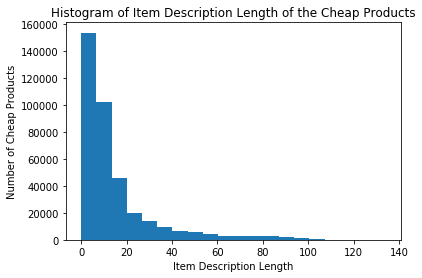

In [ ]:
# Histogram plot of the item description length for cheap product category

plt.hist(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'cheap'].item_description_Length.values, bins = 20)
plt.xlabel("Item Description Length")
plt.ylabel("Number of Cheap Products")
plt.title("Histogram of Item Description Length of the Cheap Products")

#### AFFORDABLE PRODUCT CATEGORY ITEM DESCRIPTION LENGTH ANALYSIS

In [ ]:
# Checking the minimum and maximum item_description_length for the affordable product category

min_affordable = min(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'affordable'].item_description_Length.values)
max_affordable = max(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'affordable'].item_description_Length.values)

In [ ]:
print("The minimum length of the item description for the affordable product category is : {}".format(min_affordable))
print("The maximum length of the item description for the affordable product category is : {}".format(max_affordable))

The minimum length of the item description for the affordable product category is : 0
The maximum length of the item description for the affordable product category is : 138


Text(0.5, 1.0, 'Histogram of Item Description Length of the Affordable Products')

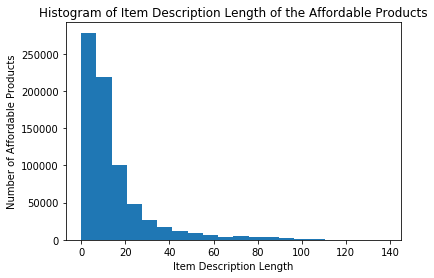

In [ ]:
# Histogram plot of the item description length for affordable product category

plt.hist(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'affordable'].item_description_Length.values, bins = 20)
plt.xlabel("Item Description Length")
plt.ylabel("Number of Affordable Products")
plt.title("Histogram of Item Description Length of the Affordable Products")

#### EXPENSIVE PRODUCT CATEGORY ITEM DESCRIPTION LENGTH ANALYSIS

In [ ]:
# Checking the minimum and maximum item_description_length for the expensive product category

min_expensive = min(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'expensive'].item_description_Length.values)
max_expensive = max(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'expensive'].item_description_Length.values)

In [ ]:
print("The minimum length of the item description for the expensive product category is : {}".format(min_expensive))
print("The maximum length of the item description for the expensive product category is : {}".format(max_expensive))

The minimum length of the item description for the expensive product category is : 0
The maximum length of the item description for the expensive product category is : 137


Text(0.5, 1.0, 'Histogram of Item Description Length of the Expensive Products')

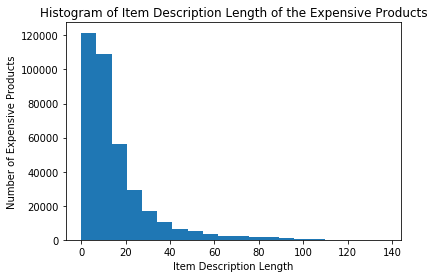

In [ ]:
# Histogram plot of the item description length for expensive product category

plt.hist(mercari_pricedata_fin[mercari_pricedata_fin['product_category'] == 'expensive'].item_description_Length.values, bins = 20)
plt.xlabel("Item Description Length")
plt.ylabel("Number of Expensive Products")
plt.title("Histogram of Item Description Length of the Expensive Products")

#### IMPORTING THE TEST DATA WITH THE SENTIMENT SCORE

In [ ]:
test_data = pd.read_csv(path + "/test_data_with_sentiment_scores.csv")

test_data.head()

,Unnamed: 0,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
0,0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000
1,1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750
2,2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000
3,3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755
4,4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531


In [ ]:
# Merging the test data with brand_avgprice dataframe

test_data = pd.merge(test_data, brand_avgprice[['brand_name','category']], how = 'left', on = ["brand_name"])


In [ ]:
print("The total number of products with null brand categories in unseen test data are {} ".format(sum(test_data['category'].isnull())))

The total number of products with null brand categories in unseen test data are 19187 


In [ ]:
# Checking the first five rows of the test_data
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000,affordable
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750,affordable
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000,expensive
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755,affordable
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531,affordable


In [ ]:
# Filling up the null brand categories with affordable as we did earlier in the test data

test_data["category"] = test_data["category"].fillna("affordable")

In [ ]:
# Checking the shape of the data

test_data.shape

(3460725, 17)

In [ ]:
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000,affordable
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750,affordable
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000,expensive
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755,affordable
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531,affordable


In [ ]:
# Creating the folder final_preprocessed_test_data
if not os.path.isdir("final_preprocessed_test_data"):
 os.mkdir("final_preprocessed_test_data")

# Writing the test_data onto the disk
test_data.to_csv("final_preprocessed_test_data/test_data_with_brand_categories.csv", index = False)

In [ ]:
test_data = pd.read_csv(path + "/test_data_with_brand_categories.csv")

test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000,affordable
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750,affordable
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000,expensive
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755,affordable
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531,affordable


In [ ]:
# Dropping the unnecessary columns from the test data

test_data = test_data.drop(["test_id","name","category_name","item_description"], axis=1)

test_data.head()


,item_condition_id,brand_name,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,1,No Brand Name,1,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000,affordable
1,1,No Brand Name,1,Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750,affordable
2,1,Coach,1,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000,expensive
3,2,No Brand Name,0,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755,affordable
4,3,No Brand Name,1,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531,affordable


#### GETTING THE FINAL FEATURE MATRIX TO TEST THE MODELS

In [ ]:
test_data["preprocessed_item_desc"] = test_data["preprocessed_item_desc"].fillna("no description")

In [ ]:
test_item_desc = vect.transform(test_data.preprocessed_item_desc.values)

In [ ]:
test_item_desc.shape

(3460725, 22282)

In [ ]:
X_tr_item_condition_le = le.fit_transform(X_tr.item_condition_id.values)
test_item_condition_le = le.transform(test_data.item_condition_id.values)
test_item_condition_le = test_item_condition_le.reshape(-1,1)

In [ ]:
custom_le.fit(X_tr.brand_name.values)

X_tr_brand_le = custom_le.transform(X_tr.brand_name.values)
test_brand_le = custom_le.transform(test_data.brand_name.values)
test_brand_le = test_brand_le.reshape(-1,1)

In [ ]:
X_tr_shipping_le = le.fit_transform(X_tr.shipping.values)

test_shipping_le = le.transform(test_data.shipping.values)
test_shipping_le = test_shipping_le.reshape(-1,1)

In [ ]:
X_tr_general_cat_le = le.fit_transform(X_tr.general_cat.values)

test_general_cat_le = le.transform(test_data.general_cat.values)
test_general_cat_le = test_general_cat_le.reshape(-1,1)

In [ ]:
X_tr_subcat_1_le = le.fit_transform(X_tr.subcat_1.values)

test_subcat_1_le = le.transform(test_data.subcat_1.values)
test_subcat_1_le = test_subcat_1_le.reshape(-1,1)

In [ ]:
custom_le.fit(X_tr.subcat_2.values)

X_tr_subcat_2_le = custom_le.transform(X_tr.subcat_2.values)
test_subcat_2_le = custom_le.transform(test_data.subcat_2.values)
test_subcat_2_le = test_subcat_2_le.reshape(-1,1)

In [ ]:
X_tr_brand_cat_le = le.fit_transform(X_tr.category.values)

test_brand_cat_le = le.fit_transform(test_data.category.values)
test_brand_cat_le = test_brand_cat_le.reshape(-1,1)

In [ ]:
np.unique(test_data.category.values)

array(['affordable', 'cheap', 'expensive'], dtype=object)

#### Preparing the final feature matrix

In [ ]:
test_britemdesc_brandcat = hstack((test_brand_le, test_item_desc, test_brand_cat_le))
test_fin = hstack((test_item_condition_le,test_britemdesc_brandcat,test_shipping_le,test_general_cat_le,test_subcat_1_le,test_subcat_2_le,test_data.item_description_Length.values.reshape(-1,1),test_data.neg.values.reshape(-1,1),test_data.neu.values.reshape(-1,1),test_data.pos.values.reshape(-1,1),test_data.compound.values.reshape(-1,1)))

In [ ]:
# Deleting the test_data df

#del test_data
#del X_tr
#del Y_tr
#del X_cv_rest
#del Y_cv_rest
#del X_cv_tune
#del Y_cv_tune
#del X_test
#del Y_test
#del test_item_desc

#### PREDICTING ON THE TEST DATA

#### RANDOM_FOREST_REGRESSOR

In [ ]:
base_estimators = 500
max_depth = 20
rf_rgsr=RandomForestRegressor(n_estimators=base_estimators,max_depth=max_depth,random_state=42,n_jobs=-1)
rf_rgsr.fit(X_cv_fin,Y_CV)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
#import scipy
#test_fin_1 = scipy.sparse.csr.csr_matrix(test_fin)[0:1000000]
predict_y_test_fin_1 = rf_rgsr.predict(test_fin_1)

In [ ]:
predictions_rfr_1 = pd.DataFrame(predict_y_test_fin_1, columns = ["price"])
predictions_rfr_1.to_csv(path + "/predictions_rfr_stg2_1.csv")

In [ ]:
#test_fin_2 = scipy.sparse.csr.csr_matrix(test_fin)[1000000:2000000]
predict_y_test_fin_2 = rf_rgsr.predict(test_fin_2)

In [ ]:
predictions_rfr_2 = pd.DataFrame(predict_y_test_fin_2, columns = ["price"])
predictions_rfr_2.to_csv(path + "/predictions_rfr_stg2_2.csv")

In [ ]:
#test_fin_3 = scipy.sparse.csr.csr_matrix(test_fin)[2000000:3460725]
predict_y_test_fin_3 = rf_rgsr.predict(test_fin_3)

In [ ]:
predictions_rfr_3 = pd.DataFrame(predict_y_test_fin_3, columns = ["price"])
predictions_rfr_3.to_csv(path + "/predictions_rfr_stg2_3.csv")

In [ ]:
predictions_rfr_3[0:5]

,price
0,26.510926
1,26.510926
2,26.510926
3,26.510926
4,26.510926


In [ ]:
# Importing all the three predictions

predictions_rfr_1 = pd.read_csv("Sample Submission/predictions_rfr_stg2_1.csv")
predictions_rfr_2 = pd.read_csv("Sample Submission/predictions_rfr_stg2_2.csv")
predictions_rfr_3 = pd.read_csv("Sample Submission/predictions_rfr_stg2_3.csv")

In [ ]:
# Renaming the columns of the three dfs

predictions_rfr_1.columns = ["test_id","price"]
predictions_rfr_2.columns = ["test_id","price"]
predictions_rfr_3.columns = ["test_id","price"]

In [ ]:
# Concatenating the three dfs into one

predictions_rfr_stg2 = pd.concat([predictions_rfr_1,predictions_rfr_2,predictions_rfr_3], axis=0)

predictions_rfr_stg2.shape

(3460725, 2)

In [ ]:
predictions_rfr_stg2["test_id"] = [i for i in range(predictions_rfr_stg2.shape[0])]

predictions_rfr_stg2.test_id.values

array([      0,       1,       2, ..., 3460722, 3460723, 3460724],
      dtype=int64)

In [ ]:
predictions_rfr_stg2.head()

,test_id,price
0,0,26.510926
1,1,26.510926
2,2,26.510926
3,3,26.510926
4,4,26.510926


In [ ]:
# Writing the predictions file back to the disk

predictions_rfr_stg2.to_csv("Sample Submission/predictions_rfr_stg2.csv", index = False)

#### KAGGLE SCREENSHOT:-

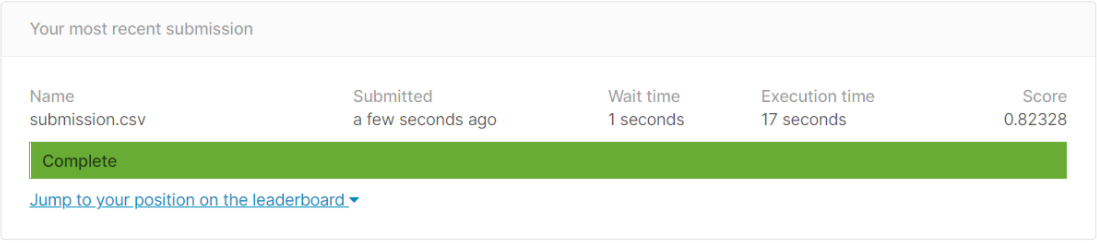

#### XGBOOST REGRESSOR

In [ ]:
import scipy

base_estimators = 100
max_depth = 5
lr = 0.01
colsample_bytree = 0.5
subsample = 0.3

X_cv_fin_sparse = scipy.sparse.csr.csr_matrix(X_cv_fin)

fin_x_rgsr=XGBRegressor(n_estimators=base_estimators,max_depth=max_depth,learning_rate = lr,colsample_bytree = colsample_bytree,subsample = subsample,random_state=42,n_jobs=-1)
fin_x_rgsr.fit(X_cv_fin_sparse,Y_CV)

[15:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.3, verbosity=1)

In [ ]:
#test_fin_1 = scipy.sparse.csr.csr_matrix(test_fin)[0:1000000]
predict_y_test_fin_1 = fin_x_rgsr.predict(test_fin_1)

In [ ]:
predictions_xgbr_1 = pd.DataFrame(predict_y_test_fin_1, columns = ["price"])
predictions_xgbr_1.to_csv(path + "/predictions_xgbr_stg2_1.csv")

In [ ]:
#test_fin_2 = scipy.sparse.csr.csr_matrix(test_fin)[1000000:2000000]
predict_y_test_fin_2 = fin_x_rgsr.predict(test_fin_2)

In [ ]:
predictions_xgbr_2 = pd.DataFrame(predict_y_test_fin_2, columns = ["price"])
predictions_xgbr_2.to_csv(path + "/predictions_xgbr_stg2_2.csv")

In [ ]:
#test_fin_3 = scipy.sparse.csr.csr_matrix(test_fin)[2000000:3460725]
predict_y_test_fin_3 = fin_x_rgsr.predict(test_fin_3)

In [ ]:
predictions_xgbr_3 = pd.DataFrame(predict_y_test_fin_3, columns = ["price"])
predictions_xgbr_3.to_csv(path + "/predictions_xgbr_stg2_3.csv")

In [ ]:
# Importing all the three predictions

predictions_xgbr_1 = pd.read_csv("Sample Submission/predictions_xgbr_stg2_1.csv")
predictions_xgbr_2 = pd.read_csv("Sample Submission/predictions_xgbr_stg2_2.csv")
predictions_xgbr_3 = pd.read_csv("Sample Submission/predictions_xgbr_stg2_3.csv")

In [ ]:
# Renaming the columns of the three dfs

predictions_xgbr_1.columns = ["test_id","price"]
predictions_xgbr_2.columns = ["test_id","price"]
predictions_xgbr_3.columns = ["test_id","price"]

In [ ]:
# Concatenating the three dfs into one

predictions_xgbr_sg2 = pd.concat([predictions_xgbr_1,predictions_xgbr_2,predictions_xgbr_3], axis=0)

predictions_xgbr_sg2.shape


(3460725, 2)

In [ ]:
predictions_xgbr_sg2["test_id"] = [i for i in range(predictions_xgbr_sg2.shape[0])]

In [ ]:
predictions_xgbr_sg2.test_id.values

array([      0,       1,       2, ..., 3460722, 3460723, 3460724],
      dtype=int64)

In [ ]:
# Writing the predictions file back to the disk

predictions_xgbr_sg2.to_csv("Sample Submission/predictions_xgbr_stg2.csv", index = False)

#### KAGGLE SCREENSHOT:-

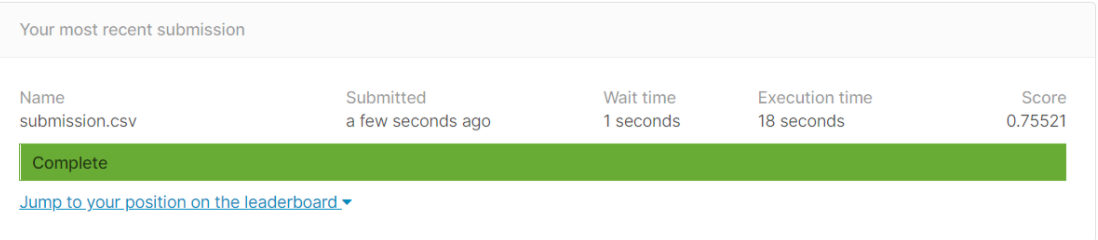

#### DECISION TREE REGRESSOR

In [ ]:
criterion = 'friedman_mse'
max_depth = 30
min_samples_split = 3
max_features = 'log2'

fin_DT_rgsr=DecisionTreeRegressor(criterion = criterion,max_depth = max_depth,min_samples_split = min_samples_split,max_features = max_features,random_state=42)
fin_DT_rgsr.fit(X_cv_fin,Y_CV)
predict_y_test_fin = fin_DT_rgsr.predict(test_fin)

In [ ]:
predictions_DT = pd.DataFrame(predict_y_test_fin, columns = ["price"])

In [ ]:
# Making the folder Sample Submission

if not os.path.isdir("Sample Submission"):
    os.mkdir("Sample Submission")

predictions_DT.to_csv("Sample Submission/predictions_DTR_stg2.csv")

In [ ]:
predictions_DT = pd.read_csv("Sample Submission/predictions_DTR_stg2.csv")

In [ ]:
predictions_DT.shape

(3460725, 2)

In [ ]:
predictions_DT.head()

,Unnamed: 0,price
0,0,26.595587
1,1,26.595587
2,2,26.595587
3,3,26.595587
4,4,26.595587


In [ ]:
predictions_DT.columns = ["test_id","price"]

In [ ]:
predictions_DT.to_csv("Sample Submission/predictions_DTR_stg2.csv", index=False)

#### KAGGLE SCREENSHOT:-

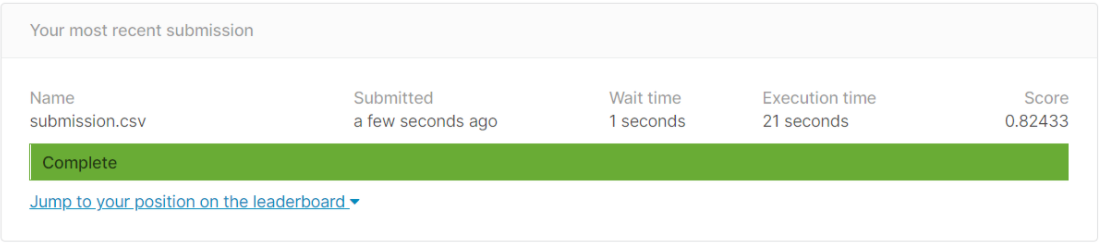

#### ADABOOST REGRESSOR

In [ ]:
n_estimators = 50
loss = 'square'
lr = 0.01

fin_ab_rgsr=AdaBoostRegressor(n_estimators = n_estimators,loss = loss,learning_rate = lr,random_state=42)
fin_ab_rgsr.fit(X_cv_fin,Y_CV)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='square',
                  n_estimators=50, random_state=42)

In [ ]:
import scipy

test_fin_1 = scipy.sparse.csr.csr_matrix(test_fin)[0:1000000]

predict_y_test_fin_1 = fin_ab_rgsr.predict(test_fin_1)

In [ ]:
predictions_ab_1 = pd.DataFrame(predict_y_test_fin_1, columns = ["price"])

predictions_ab_1.to_csv(path + "/predictions_abrgsr_stg2_1.csv")

In [ ]:
test_fin_2 = scipy.sparse.csr.csr_matrix(test_fin)[1000000:2000000]

predict_y_test_fin_2 = fin_ab_rgsr.predict(test_fin_2)

In [ ]:
predictions_ab_2 = pd.DataFrame(predict_y_test_fin_2, columns = ["price"])

predictions_ab_2.to_csv(path + "/predictions_abrgsr_stg2_2.csv")

In [ ]:
test_fin_3 = scipy.sparse.csr.csr_matrix(test_fin)[2000000:3460725]

predict_y_test_fin_3 = fin_ab_rgsr.predict(test_fin_3)

In [ ]:
predictions_ab_3 = pd.DataFrame(predict_y_test_fin_3, columns = ["price"])

predictions_ab_3.to_csv(path + "/predictions_abrgsr_stg2_3.csv")

In [ ]:
# Making the folder Sample Submission

if not os.path.isdir("Sample Submission"):
    os.mkdir("Sample Submission")

predictions_ab.to_csv("Sample Submission/predictions_abrgsr_stg2.csv")

In [ ]:
# Importing all the three predictions

predictions_abrgsr_1 = pd.read_csv("Sample Submission/predictions_abrgsr_stg2_1.csv")
predictions_abrgsr_2 = pd.read_csv("Sample Submission/predictions_abrgsr_stg2_2.csv")
predictions_abrgsr_3 = pd.read_csv("Sample Submission/predictions_abrgsr_stg2_3.csv")

In [ ]:
# Renaming the columns of the three dfs

predictions_abrgsr_1.columns = ["test_id","price"]
predictions_abrgsr_2.columns = ["test_id","price"]
predictions_abrgsr_3.columns = ["test_id","price"]

In [ ]:
# Concatenating the three dfs into one

predictions_abrgsr_stg2 = pd.concat([predictions_abrgsr_1,predictions_abrgsr_2,predictions_abrgsr_3], axis=0)

predictions_abrgsr_stg2.shape

(3460725, 2)

In [ ]:
predictions_abrgsr_stg2["test_id"] = [i for i in range(predictions_abrgsr_stg2.shape[0])]

In [ ]:
predictions_abrgsr_stg2.test_id.values

array([      0,       1,       2, ..., 3460722, 3460723, 3460724],
      dtype=int64)

In [ ]:
# Writing the predictions file back to the disk

predictions_abrgsr_stg2.to_csv("Sample Submission/predictions_abrgsr_stg2.csv", index = False)

#### KAGGLE SCREENSHOT:-

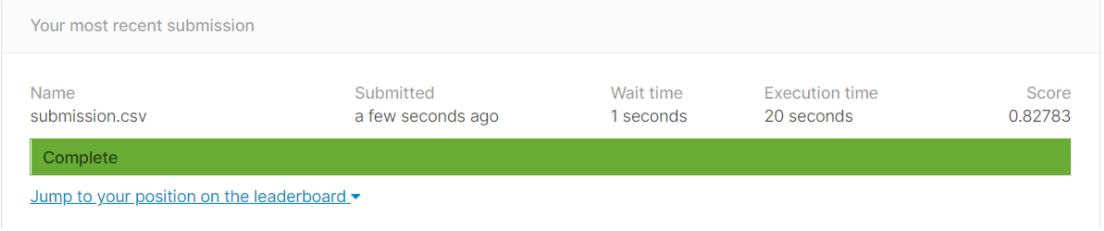

#### SGDREGRESSOR WITH L2 PENALTY

In [ ]:
regularization_strength = 0.001
lr = 'optimal'
loss = 'epsilon_insensitive'

fin_ridge_rgsr=SGDRegressor(loss = loss,alpha = regularization_strength,learning_rate = lr, penalty = 'l2',random_state=42)
fin_ridge_rgsr.fit(X_cv_fin,Y_CV)

SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='epsilon_insensitive', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
#test_fin_1 = scipy.sparse.csr.csr_matrix(test_fin)[0:1000000]

predict_y_test_fin_1 = fin_ridge_rgsr.predict(test_fin_1)

In [ ]:
predictions_ridge_1 = pd.DataFrame(predict_y_test_fin_1, columns = ["price"])
predictions_ridge_1.to_csv(path + "/predictions_ridge_stg2_1.csv")

In [ ]:
#test_fin_2 = scipy.sparse.csr.csr_matrix(test_fin)[1000000:2000000]

predict_y_test_fin_2 = fin_ridge_rgsr.predict(test_fin_2)

In [ ]:
predictions_ridge_2 = pd.DataFrame(predict_y_test_fin_2, columns = ["price"])
predictions_ridge_2.to_csv(path + "/predictions_ridge_stg2_2.csv")

In [ ]:
#test_fin_2 = scipy.sparse.csr.csr_matrix(test_fin)[2000000:3460725]

predict_y_test_fin_3 = fin_ridge_rgsr.predict(test_fin_3)

In [ ]:
predictions_ridge_3 = pd.DataFrame(predict_y_test_fin_3, columns = ["price"])
predictions_ridge_3.to_csv(path + "/predictions_ridge_stg2_3.csv")

In [ ]:
# Importing all the three predictions

predictions_ridge_1 = pd.read_csv("Sample Submission/predictions_ridge_stg2_1.csv")
predictions_ridge_2 = pd.read_csv("Sample Submission/predictions_ridge_stg2_2.csv")
predictions_ridge_3 = pd.read_csv("Sample Submission/predictions_ridge_stg2_3.csv")

In [ ]:
# Renaming the columns of the three dfs

predictions_ridge_1.columns = ["test_id","price"]
predictions_ridge_2.columns = ["test_id","price"]
predictions_ridge_3.columns = ["test_id","price"]

In [ ]:
# Concatenating the three dfs into one

predictions_ridge_stg2 = pd.concat([predictions_ridge_1,predictions_ridge_2,predictions_ridge_3], axis=0)

predictions_ridge_stg2.shape

(3460725, 2)

In [ ]:
predictions_ridge_stg2["test_id"] = [i for i in range(predictions_ridge_stg2.shape[0])]

predictions_ridge_stg2.test_id.values

array([      0,       1,       2, ..., 3460722, 3460723, 3460724],
      dtype=int64)

In [ ]:
# Writing the predictions file back to the disk

predictions_ridge_stg2.to_csv("Sample Submission/predictions_ridge_stg2.csv", index = False)

#### KAGGLE SCREENSHOT:-

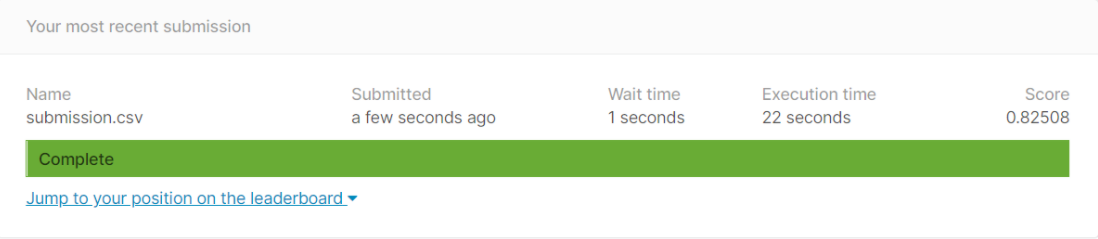

#### OBSERVATION:-

1) The best model was XGBoost Regressor which performed better than the random model on the unseen test data with a RMSLE of close to 0.7552.

### DEEP LEARNING MODEL:-

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM

In [3]:
# Defining the path

path = "/content/drive/MyDrive/Self_Case_Study_1"

In [4]:
# Importing the file
mercari_preprocessed_data = pd.read_csv(path + "/mercari_pricedata_product_category.csv")
#mercari_preprocessed_data = pd.read_csv("mercari_pricedata_product_category/mercari_pricedata_product_category.csv")

In [5]:
# Checking the first five rows of the data

mercari_preprocessed_data.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,product_category
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,1,description yet,0.0,1.000,0.000,0.0000,cheap
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,14,keyboard great condition works like came box p...,0.0,0.565,0.435,0.8957,expensive
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,10,adorable top hint lace key hole back pale pink...,0.0,0.667,0.333,0.6124,cheap
3,3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,No Brand Name,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,14,new tags leather horses retail stand foot high...,0.0,0.728,0.272,0.6808,expensive
4,4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,No Brand Name,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,3,complete certificate authenticity,0.0,1.000,0.000,0.0000,expensive


### TRAIN TEST SPLIT

In [6]:
#Getting the dataframes of the features and response

X = mercari_preprocessed_data.drop(["Unnamed: 0","train_id","name","category_name","log_price","item_description","product_category"], axis=1)
Y = mercari_preprocessed_data["price"]

In [7]:
Y = Y.astype(dtype='float32', copy=True)

In [8]:
# Splitting the data into train and test on the original price variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

In [9]:
# Filling out the na values in the preprocessed item_description with No description

X_train["preprocessed_item_desc"] = X_train["preprocessed_item_desc"].fillna("no description")
X_test["preprocessed_item_desc"] = X_test["preprocessed_item_desc"].fillna("no description")

In [10]:
X_train.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
204717,1,Nike,12.0,0,Kids,Boys 0-24 Mos,Accessories,10,new tags nike socks months crawler socks top g...,0.00,0.859,0.141,0.2023
231882,3,Nerf,20.0,0,Sports & Outdoors,Outdoors,Indoor,3,one drum mag round mags,0.00,1.000,0.000,0.0000
1274186,1,PINK,9.0,0,Women,Underwear,Panties,6,free ship price firm bundle okay,0.00,0.435,0.565,0.6369
269654,1,Victoria's Secret,20.0,0,Women,Athletic Apparel,"Pants, Tights, Leggings",6,nwt paid love pregnant gonna fit right,0.00,0.427,0.573,0.7717
1008253,2,Pokemon,3.0,1,Vintage & Collectibles,Trading Cards,Animation,64,seel reverse holo sleeve mint weedle reverse h...,0.08,0.836,0.085,0.1027


In [11]:
X_test.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound
777341,1,No Brand Name,12.0,1,Handmade,Paper Goods,Stationery,17,listing totoro washi tape limited time offer a...,0.095,0.905,0.000,-0.2263
1463629,1,Adidas,76.0,1,Women,Other,Other,1,items,0.000,1.000,0.000,0.0000
350669,1,No Brand Name,12.0,1,Beauty,Makeup,Lips,2,sunglasses necklace,0.000,1.000,0.000,0.0000
310222,1,No Brand Name,3.0,1,Kids,Toys,Arts & Crafts,7,ordered bunch stickers recieve many cute ones,0.000,0.667,0.333,0.4588
759257,2,Chanel,30.0,1,Beauty,Makeup,Lips,7,brand new never used authentic mini lipgloss g...,0.000,0.734,0.266,0.4404


#### IMPORTING THE BRAND LEVEL AVERAGE PRICES

In [12]:
brand_avgprice = pd.read_csv(path + "/brand_level_average_prices.csv")

In [13]:
brand_avgprice.head()

,brand_name,price,category
0,Proenza Schouler,435.666667,expensive
1,Demdaco,431.500000,expensive
2,Oris,300.000000,expensive
3,MCM Worldwide,277.886792,expensive
4,Rick Owens,259.000000,expensive


#### MERGING THE BRAND LEVEL AVERAGE PRICES WITH THE TRAIN AND THE TEST DATA

In [14]:
# Merging the table brand_avgprice and the X_train

X_train = pd.merge(X_train, brand_avgprice[["brand_name", "category"]], how = "inner", on=["brand_name"])

X_train.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,1,Nike,12.0,0,Kids,Boys 0-24 Mos,Accessories,10,new tags nike socks months crawler socks top g...,0.0,0.859,0.141,0.2023,expensive
1,1,Nike,34.0,0,Women,Sweaters,Hooded,16,size women retail lot nike deals visit closet ...,0.0,0.809,0.191,0.5106,expensive
2,3,Nike,10.0,1,Women,Tops & Blouses,T-Shirts,2,wore comfy,0.0,1.000,0.000,0.0000,expensive
3,3,Nike,19.0,0,Kids,Boys 0-24 Mos,Shoes,4,nike jordan good condition,0.0,0.508,0.492,0.4404,expensive
4,2,Nike,27.0,0,Men,Men's Accessories,Hats,1,description yet,0.0,1.000,0.000,0.0000,expensive


In [15]:
# Getting the categories of brands in the test data

X_test = pd.merge(X_test, brand_avgprice[["brand_name", "category"]], how = "left", on=["brand_name"])

X_test.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,1,No Brand Name,12.0,1,Handmade,Paper Goods,Stationery,17,listing totoro washi tape limited time offer a...,0.095,0.905,0.000,-0.2263,affordable
1,1,Adidas,76.0,1,Women,Other,Other,1,items,0.000,1.000,0.000,0.0000,expensive
2,1,No Brand Name,12.0,1,Beauty,Makeup,Lips,2,sunglasses necklace,0.000,1.000,0.000,0.0000,affordable
3,1,No Brand Name,3.0,1,Kids,Toys,Arts & Crafts,7,ordered bunch stickers recieve many cute ones,0.000,0.667,0.333,0.4588,affordable
4,2,Chanel,30.0,1,Beauty,Makeup,Lips,7,brand new never used authentic mini lipgloss g...,0.000,0.734,0.266,0.4404,expensive


In [16]:
# Checking the shape of the training data

X_train.shape

(1111901, 14)

In [17]:
# Checking the shape of the test data

X_test.shape

(370634, 14)

In [32]:
X_train.to_csv("X_train.csv", index=False)

In [33]:
del mercari_pricedata_fin

In [18]:
# Checking the number of null values in the category column of the X_test

print("The total number of products with no brand categories in splitted test data are {} ".format(sum(X_test['category'].isnull())))

The total number of products with no brand categories in splitted test data are 277 


In [19]:
# Checking the category corresponding to No Brand Name in the X_train

np.unique(X_train[X_train['brand_name'] == 'No Brand Name']['category'].values)

array(['affordable'], dtype=object)

In [20]:
# Filling out the na values in the X_test category column by affordable

X_test["category"] = X_test["category"].fillna("affordable")

In [21]:
# Checking the unique values of category in X_test

np.unique(X_test.category.values)

array(['affordable', 'cheap', 'expensive'], dtype=object)

In [22]:
X_train.drop(["price"], axis=1, inplace=True)

In [23]:
X_test.drop(["price"], axis=1, inplace=True)

In [24]:
# Checking for null values in the dataframe X_train
X_train.isnull().values.any()

False

In [25]:
# Checking for null values in the dataframe X_test
X_test.isnull().values.any()

False

#### CREATING SEQUENCES AND EMBEDDING THE PREPROCESSED ITEM DESCRIPTION

In [4]:
X_train = pd.read_csv("X_train.csv")

In [18]:
X_train.head()

,item_condition_id,brand_name,price,shipping,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,1,Nike,12.0,0,Kids,Boys 0-24 Mos,Accessories,10,new tags nike socks months crawler socks top g...,0.0,0.859,0.141,0.2023,expensive
1,1,Nike,34.0,0,Women,Sweaters,Hooded,16,size women retail lot nike deals visit closet ...,0.0,0.809,0.191,0.5106,expensive
2,3,Nike,10.0,1,Women,Tops & Blouses,T-Shirts,2,wore comfy,0.0,1.000,0.000,0.0000,expensive
3,3,Nike,19.0,0,Kids,Boys 0-24 Mos,Shoes,4,nike jordan good condition,0.0,0.508,0.492,0.4404,expensive
4,2,Nike,27.0,0,Men,Men's Accessories,Hats,1,description yet,0.0,1.000,0.000,0.0000,expensive


In [19]:
# Checking the length of the words in the essays

train_preprocessed_item_desc_len = []

for text in list(X_train["preprocessed_item_desc"]):
    if isinstance(text,float):
        text = str(text)
        train_preprocessed_item_desc_len.append(len(text.split()))
    else:
        train_preprocessed_item_desc_len.append(len(text.split()))

pad_len = max(train_preprocessed_item_desc_len)

print("The maximum length of the preprocessed item description in the train data is {} ".format(pad_len))

The maximum length of the preprocessed item description in the train data is 149 


In [20]:
train_item_desc_list = []
for text in list(X_train["preprocessed_item_desc"]):
    if isinstance(text,float):
        text = str(text)
        train_item_desc_list.append(text)
    else:
        train_item_desc_list.append(text)

In [21]:
test_item_desc_list = []
for text in list(X_test["preprocessed_item_desc"]):
    if isinstance(text,float):
        text = str(text)
        test_item_desc_list.append(text)
    else:
        test_item_desc_list.append(text)

In [22]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_item_desc = int(pad_len)

# Source:- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

#Tokenizing the training data and fitting the tokenizer on the training data
Tokenizer_item_desc = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token = oov_token)# 
Tokenizer_item_desc.fit_on_texts(train_item_desc_list)

# Creating the dictionaries word_index and index_word
word_index_item_desc = Tokenizer_item_desc.word_index
index_word_item_desc = Tokenizer_item_desc.index_word

# Creating the train and test padded sequences
input_item_desc_train_sequences = Tokenizer_item_desc.texts_to_sequences(train_item_desc_list)# Encoding test data sentences into sequences
input_item_desc_train_padded_sequences = pad_sequences(input_item_desc_train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_item_desc) # Padding the sequences in training data
print("\nPadded training shape:", input_item_desc_train_padded_sequences.shape)# Output the results of our work
input_item_desc_test_sequences = Tokenizer_item_desc.texts_to_sequences(test_item_desc_list)# Encoding test data sentences into sequences
input_item_desc_test_padded_sequences = pad_sequences(input_item_desc_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_item_desc)# Padding the sequences in test data
print("\nPadded test shape:", input_item_desc_test_padded_sequences.shape)


Padded training shape: (1111901, 149)

Padded test shape: (370634, 149)


In [23]:
print("The length of the word_index dictionary of the preprocessed item description is : {} ".format(len(word_index_item_desc)))

The length of the word_index dictionary of the preprocessed item description is : 111918 


In [24]:
# Creating embeddings for the item_description

embeddings_index = dict()
f = open(path + '/glove.6B.300d.txt', encoding = "utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((111919, 300))
for word, i in word_index_item_desc.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
type(embedding_matrix)

numpy.ndarray

#### CREATING SEQUENCES FOR THE BRAND NAME

In [25]:
# Checking the length of the words in the brand names

train_preprocessed_brand_name = []

for text in list(X_train["brand_name"]):
    if isinstance(text,float):
        text = str(text)
        train_preprocessed_brand_name.append(len(text.split()))
    else:
        train_preprocessed_brand_name.append(len(text.split()))

pad_len_brand = max(train_preprocessed_brand_name)

print("The maximum length of the brand name in the train data is {} ".format(pad_len_brand))

The maximum length of the brand name in the train data is 6 


In [26]:
train_brand_name_list = []
for brand in list(X_train["brand_name"]):
    if isinstance(brand,float):
        brand = str(brand)
        train_brand_name_list.append(brand)
    else:
        train_brand_name_list.append(brand)
        
test_brand_name_list = []
for brand in list(X_test["brand_name"]):
    if isinstance(brand,float):
        brand = str(brand)
        test_brand_name_list.append(brand)
    else:
        test_brand_name_list.append(brand)

In [27]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_brand = int(pad_len_brand)

# Source:- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

# Tokenizing the training data and fitting the tokenizer on the training data
Tokenizer_brand = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
Tokenizer_brand.fit_on_texts(train_brand_name_list)

# Creating the dictionaries word_index and index_word
word_index_brand = Tokenizer_brand.word_index
index_word_brand = Tokenizer_brand.index_word

# Creating the train and test padded sequences
input_brand_train_sequences = Tokenizer_brand.texts_to_sequences(train_brand_name_list)# Encoding test data sentences into sequences
input_brand_train_padded_sequences = pad_sequences(input_brand_train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_brand) # Padding the sequences in training data
print("\nPadded training shape:", input_brand_train_padded_sequences.shape)# Output the results of our work
input_brand_test_sequences = Tokenizer_brand.texts_to_sequences(test_brand_name_list)# Encoding test data sentences into sequences
input_brand_test_padded_sequences = pad_sequences(input_brand_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_brand)# Padding the sequences in test data
print("\nPadded test shape:", input_brand_test_padded_sequences.shape)


Padded training shape: (1111901, 6)

Padded test shape: (370634, 6)


#### CREATING SEQUENCES FOR THE GENERAL_CAT FEATURE

In [28]:
# Checking the length of the words in the general_cat feature

train_preprocessed_general_cat = []

for text in list(X_train["general_cat"]):
    if isinstance(text,float):
        text = str(text)
        train_preprocessed_general_cat.append(len(text.split()))
    else:
        train_preprocessed_general_cat.append(len(text.split()))

pad_len_gen_cat = max(train_preprocessed_general_cat)

print("The maximum length of the general category in the train data is {} ".format(pad_len_gen_cat))

The maximum length of the general category in the train data is 3 


In [29]:
train_gen_cat_list = []
for gen_cat in list(X_train["general_cat"]):
    if isinstance(gen_cat,float):
        gen_cat = str(gen_cat)
        train_gen_cat_list.append(brand)
    else:
        train_gen_cat_list.append(brand)
        
test_gen_cat_list = []
for gen_cat in list(X_test["general_cat"]):
    if isinstance(gen_cat,float):
        gen_cat = str(gen_cat)
        test_gen_cat_list.append(gen_cat)
    else:
        test_gen_cat_list.append(gen_cat)

In [30]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_gen_cat = int(pad_len_gen_cat)

# Source:- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

# Tokenizing the training data and fitting the tokenizer on the training data
Tokenizer_gen_cat = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
Tokenizer_gen_cat.fit_on_texts(train_gen_cat_list)

# Creating the dictionaries word_index and index_word
word_index_gen_cat = Tokenizer_gen_cat.word_index
index_word_gen_cat = Tokenizer_gen_cat.index_word

# Creating the train and test padded sequences
input_gencat_train_sequences = Tokenizer_gen_cat.texts_to_sequences(train_gen_cat_list)# Encoding test data sentences into sequences
input_gencat_train_padded_sequences = pad_sequences(input_gencat_train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_gen_cat) # Padding the sequences in training data
print("\nPadded training shape:", input_gencat_train_padded_sequences.shape)# Output the results of our work
input_gencat_test_sequences = Tokenizer_gen_cat.texts_to_sequences(test_gen_cat_list)# Encoding test data sentences into sequences
input_gencat_test_padded_sequences = pad_sequences(input_gencat_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_gen_cat)# Padding the sequences in test data
print("\nPadded test shape:", input_gencat_test_padded_sequences.shape)


Padded training shape: (1111901, 3)

Padded test shape: (370634, 3)


#### CREATING SEQUENCES FOR SUBCAT_1 FEATURE

In [31]:
# Checking the length of the words in the general_cat feature

train_preprocessed_subcat_1 = []

for text in list(X_train["subcat_1"]):
    if isinstance(text,float):
        text = str(text)
        train_preprocessed_subcat_1.append(len(text.split()))
    else:
        train_preprocessed_subcat_1.append(len(text.split()))

pad_len_subcat_1 = max(train_preprocessed_subcat_1)

print("The maximum length of the sub category 1 in the train data is {} ".format(pad_len_subcat_1))

The maximum length of the sub category 1 in the train data is 5 


In [32]:
train_subcat1_list = []
for subcat_1 in list(X_train["subcat_1"]):
    if isinstance(subcat_1,float):
        subcat_1 = str(subcat_1)
        train_subcat1_list.append(subcat_1)
    else:
        train_subcat1_list.append(subcat_1)
        
test_subcat1_list = []
for subcat_1 in list(X_test["subcat_1"]):
    if isinstance(subcat_1,float):
        subcat_1 = str(subcat_1)
        test_subcat1_list.append(subcat_1)
    else:
        test_subcat1_list.append(subcat_1)

In [33]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_subcat_1 = int(pad_len_subcat_1)

# Source:- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

# Tokenizing the training data and fitting the tokenizer on the training data
Tokenizer_subcat_1 = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
Tokenizer_subcat_1.fit_on_texts(train_subcat1_list)

# Creating the dictionaries word_index and index_word
word_index_subcat_1 = Tokenizer_subcat_1.word_index
index_word_subcat_1 = Tokenizer_subcat_1.index_word

# Creating the train and test padded sequences
input_subcat1_train_sequences = Tokenizer_subcat_1.texts_to_sequences(train_subcat1_list)# Encoding test data sentences into sequences
input_subcat1_train_padded_sequences = pad_sequences(input_subcat1_train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_subcat_1) # Padding the sequences in training data
print("\nPadded training shape:", input_subcat1_train_padded_sequences.shape)# Output the results of our work
input_subcat1_test_sequences = Tokenizer_subcat_1.texts_to_sequences(test_subcat1_list)# Encoding test data sentences into sequences
input_subcat1_test_padded_sequences = pad_sequences(input_subcat1_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_subcat_1)# Padding the sequences in test data
print("\nPadded test shape:", input_subcat1_test_padded_sequences.shape)


Padded training shape: (1111901, 5)

Padded test shape: (370634, 5)


#### CREATING SEQUENCES FOR SUBCAT_2 FEATURE

In [34]:
# Checking the length of the words in the general_cat feature

train_preprocessed_subcat_2 = []

for text in list(X_train["subcat_2"]):
    if isinstance(text,float):
        text = str(text)
        train_preprocessed_subcat_2.append(len(text.split()))
    else:
        train_preprocessed_subcat_2.append(len(text.split()))

pad_len_subcat_2 = max(train_preprocessed_subcat_2)

print("The maximum length of the sub category 2 in the train data is {} ".format(pad_len_subcat_2))

The maximum length of the sub category 2 in the train data is 7 


In [35]:
train_subcat2_list = []
for subcat_2 in list(X_train["subcat_2"]):
    if isinstance(subcat_2,float):
        subcat_2 = str(subcat_2)
        train_subcat2_list.append(subcat_2)
    else:
        train_subcat2_list.append(subcat_2)
        
test_subcat2_list = []
for subcat_2 in list(X_test["subcat_2"]):
    if isinstance(subcat_2,float):
        subcat_2 = str(subcat_2)
        test_subcat2_list.append(subcat_2)
    else:
        test_subcat2_list.append(subcat_2)

In [36]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_subcat_2 = int(pad_len_subcat_2)

# Source:- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

# Tokenizing the training data and fitting the tokenizer on the training data
Tokenizer_subcat_2 = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
Tokenizer_subcat_2.fit_on_texts(train_subcat2_list)

# Creating the dictionaries word_index and index_word
word_index_subcat_2 = Tokenizer_subcat_2.word_index
index_word_subcat_2 = Tokenizer_subcat_2.index_word

# Creating the train and test padded sequences
input_subcat2_train_sequences = Tokenizer_subcat_2.texts_to_sequences(train_subcat2_list)# Encoding test data sentences into sequences
input_subcat2_train_padded_sequences = pad_sequences(input_subcat2_train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_subcat_2) # Padding the sequences in training data
print("\nPadded training shape:", input_subcat2_train_padded_sequences.shape)# Output the results of our work
input_subcat2_test_sequences = Tokenizer_subcat_2.texts_to_sequences(test_subcat2_list)# Encoding test data sentences into sequences
input_subcat2_test_padded_sequences = pad_sequences(input_subcat2_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_subcat_2)# Padding the sequences in test data
print("\nPadded test shape:", input_subcat2_test_padded_sequences.shape)


Padded training shape: (1111901, 7)

Padded test shape: (370634, 7)


#### CREATING THE SEQUENCES FOR BRAND CATEGORY FEATURE

In [45]:
# Checking the length of the words in the general_cat feature

train_preprocessed_br_category = []

for text in list(X_train["category"]):
    if isinstance(text,float):
        text = str(text)
        train_preprocessed_br_category.append(len(text.split()))
    else:
        train_preprocessed_br_category.append(len(text.split()))

pad_len_br_category = max(train_preprocessed_br_category)

print("The maximum length of the brand category in the train data is {} ".format(pad_len_br_category))

The maximum length of the brand category in the train data is 1 


In [46]:
train_br_category_list = []
for br_cat in list(X_train["category"]):
    if isinstance(br_cat,float):
        br_cat = str(br_cat)
        train_br_category_list.append(br_cat)
    else:
        train_br_category_list.append(br_cat)
        
test_br_category_list = []
for br_cat in list(X_test["category"]):
    if isinstance(br_cat,float):
        br_cat = str(br_cat)
        test_br_category_list.append(br_cat)
    else:
        test_br_category_list.append(br_cat)

In [47]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_br_category = int(pad_len_br_category)

# Source:- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

# Tokenizing the training data and fitting the tokenizer on the training data
Tokenizer_br_cat = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
Tokenizer_br_cat.fit_on_texts(train_br_category_list)

# Creating the dictionaries word_index and index_word
word_index_br_cat = Tokenizer_br_cat.word_index
index_word_br_cat = Tokenizer_br_cat.index_word

# Creating the train and test padded sequences
input_brcat_train_sequences = Tokenizer_br_cat.texts_to_sequences(train_br_category_list)# Encoding test data sentences into sequences
input_brcat_train_padded_sequences = pad_sequences(input_brcat_train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_br_category) # Padding the sequences in training data
print("\nPadded training shape:", input_brcat_train_padded_sequences.shape)# Output the results of our work
input_brcat_test_sequences = Tokenizer_br_cat.texts_to_sequences(test_br_category_list)# Encoding test data sentences into sequences
input_brcat_test_padded_sequences = pad_sequences(input_brcat_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_br_category)# Padding the sequences in test data
print("\nPadded test shape:", input_brcat_test_padded_sequences.shape)


Padded training shape: (1111901, 1)

Padded test shape: (370634, 1)


### NUMERICAL FEATURES HANDLING

In [63]:
# Subsetting the four numerical features
numerical_features_train = X_train.loc[:,['item_condition_id', 'shipping', 'item_description_Length','neg','pos','neu','compound']]
numerical_features_test = X_test.loc[:,['item_condition_id', 'shipping', 'item_description_Length','neg','pos','neu','compound']]

In [64]:
numerical_features_train.values

array([[ 1.    ,  0.    , 10.    , ...,  0.141 ,  0.859 ,  0.2023],
       [ 1.    ,  0.    , 16.    , ...,  0.191 ,  0.809 ,  0.5106],
       [ 3.    ,  1.    ,  2.    , ...,  0.    ,  1.    ,  0.    ],
       ...,
       [ 2.    ,  1.    , 27.    , ...,  0.306 ,  0.634 ,  0.872 ],
       [ 2.    ,  0.    ,  8.    , ...,  0.    ,  0.574 , -0.6367],
       [ 2.    ,  0.    , 31.    , ...,  0.466 ,  0.491 ,  0.9661]])

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numerical_features_train_scaled = scaler.fit_transform(numerical_features_train.values)
numerical_features_test_scaled = scaler.transform(numerical_features_test.values)

In [66]:
numerical_features_train_scaled

array([[0.        , 0.        , 0.07246377, ..., 0.141     , 0.859     ,
        0.60074178],
       [0.        , 0.        , 0.11594203, ..., 0.191     , 0.809     ,
        0.75526263],
       [0.5       , 1.        , 0.01449275, ..., 0.        , 1.        ,
        0.49934844],
       ...,
       [0.25      , 1.        , 0.19565217, ..., 0.306     , 0.634     ,
        0.93639735],
       [0.25      , 0.        , 0.05797101, ..., 0.        , 0.574     ,
        0.18023256],
       [0.25      , 0.        , 0.22463768, ..., 0.466     , 0.491     ,
        0.98356055]])

In [67]:
print("The number of unique brand names in the training data are : {} ".format(len(X_train.brand_name.value_counts())))

The number of unique brand names in the training data are : 4578 


In [68]:
print("The number of unique general_cat in the training data are : {} ".format(len(X_train.general_cat.value_counts())))

The number of unique general_cat in the training data are : 11 


In [69]:
print("The number of unique subcat_1 values in the training data are : {}".format(len(X_train.subcat_1.value_counts())))

The number of unique subcat_1 values in the training data are : 114


In [70]:
print("The number of unique subcat_2 values in the training data are : {}".format(len(X_train.subcat_2.value_counts())))

The number of unique subcat_2 values in the training data are : 854


In [71]:
print("The number of unique brand category values in the training data are : {}".format(len(X_train.category.value_counts())))

The number of unique brand category values in the training data are : 3


In [72]:
print("The length of the word index dictionary of brands is {} ".format(len(word_index_brand)))

The length of the word index dictionary of brands is 4908 


In [73]:
print("The length of the word index dictionary of general_cat is {} ".format(len(word_index_gen_cat)))

The length of the word index dictionary of general_cat is 4 


In [74]:
print("The length of the word index dictionary of subcat_1 is {} ".format(len(word_index_subcat_1)))

The length of the word index dictionary of subcat_1 is 146 


In [75]:
print("The length of the word index dictionary of subcat_2 is {} ".format(len(word_index_subcat_2)))

The length of the word index dictionary of subcat_2 is 957 


In [76]:
print("The length of the word index dictionary of preprocessed item_description is {} ".format(len(word_index_item_desc)))

The length of the word index dictionary of preprocessed item_description is 111918 


In [77]:
print("The length of the word index dictionary of brand category is {} ".format(len(index_word_br_cat)))

The length of the word index dictionary of brand category is 4 


#### MODEL ARCHITECTURE

In [37]:
# Embedding Layer dimensions and num_tokens for other inputs
#embedding_dim_schst = 50
embedding_dim_brand = min(4578//2, 50)
num_tokens_brand = 4909
#embedding_dim_prgrcat = 50
embedding_dim_general_cat = min(11//2, 50)
num_tokens_gencat = 5
#embedding_dim_projcat = 100
embedding_dim_subcat_1 = min(114//2, 50)
num_tokens_subcat_1 = 147
#embedding_dim_projsubcat = 100
embedding_dim_subcat_2 = min(854//2, 50)
num_tokens_subcat_2 = 958
#embedding_dim_teachpref = 50
embedding_dim_brcat = min(3//2, 50)
num_tokens_brcat = 5
# Embedding Dimensions for preprocessed_item_description
embedding_dim_preprocessed_itemdesc = 300
num_tokens_preprocessed_itemdesc = 111919

# Creating the model architecture
Inp1 = Input(shape = (149,), dtype='int64')
Emb1 = Embedding(input_dim = num_tokens_preprocessed_itemdesc, output_dim = embedding_dim_preprocessed_itemdesc, input_length = 149,
                embeddings_initializer = keras.initializers.constant(embedding_matrix), trainable = False)(Inp1)
LSTM_layer = LSTM(units = 50, return_sequences = True)(Emb1)
Flatten_1 = Flatten()(LSTM_layer)

Inp2 = Input(shape = (6,), dtype='int64')
Emb2 = Embedding(input_dim = num_tokens_brand, output_dim = embedding_dim_brand, input_length = 6,trainable = True)(Inp2)
Flatten_2 = Flatten()(Emb2)

Inp3 = Input(shape = (3,), dtype='int64')
Emb3 = Embedding(input_dim = num_tokens_gencat, output_dim = embedding_dim_general_cat, input_length = 3,trainable = True)(Inp3)
Flatten_3 = Flatten()(Emb3)

Inp4 = Input(shape = (5,), dtype='int64')
Emb4 = Embedding(input_dim = num_tokens_subcat_1, output_dim = embedding_dim_subcat_1, input_length = 5,trainable = True)(Inp4)
Flatten_4 = Flatten()(Emb4)

Inp5 = Input(shape = (7,), dtype='int64')
Emb5 = Embedding(input_dim = num_tokens_subcat_2, output_dim = embedding_dim_subcat_2, input_length = 7,trainable = True)(Inp5)
Flatten_5 = Flatten()(Emb5)

Inp6 = Input(shape = (1,), dtype='int64')
Emb6 = Embedding(input_dim = num_tokens_brcat, output_dim = embedding_dim_brcat, input_length = 1,trainable = True)(Inp6)
Flatten_6 = Flatten()(Emb6)

Inp7 = Input(shape = (7,))
Dense_1 = Dense(units = 8, activation = 'relu', kernel_initializer = 'he_uniform')(Inp7)
#Dense_2 = Dense(units = 4, activation = 'relu', kernel_initializer = 'he_uniform')(Dense_2)

concat = concatenate([Flatten_1, Flatten_2, Flatten_3, Flatten_4, Flatten_5, Flatten_6, Dense_1])

Dense_2 = Dense(units = 256, activation = 'relu', kernel_initializer = 'he_uniform')(concat)

dropout_1 = Dropout(0.5)(Dense_2)

Dense_3 = Dense(units = 128, activation = 'relu', kernel_initializer = 'he_uniform')(dropout_1)

dropout_2 = Dropout(0.4)(Dense_3)

Dense_5 = Dense(units = 64, activation = 'relu', kernel_initializer = 'he_uniform')(dropout_2)

Output = Dense(units = 1, activation = 'relu')(Dense_5)

model = Model(inputs = [Inp1, Inp2, Inp3, Inp4, Inp5, Inp6, Inp7], outputs = [Output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 149)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 149, 300)     33575700    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________________

In [ ]:
import os

#Including the graphviz to the path
os.environ["PATH"] += os.pathsep + 'C:/Users/Wazir/Desktop/Graphviz/graphviz'

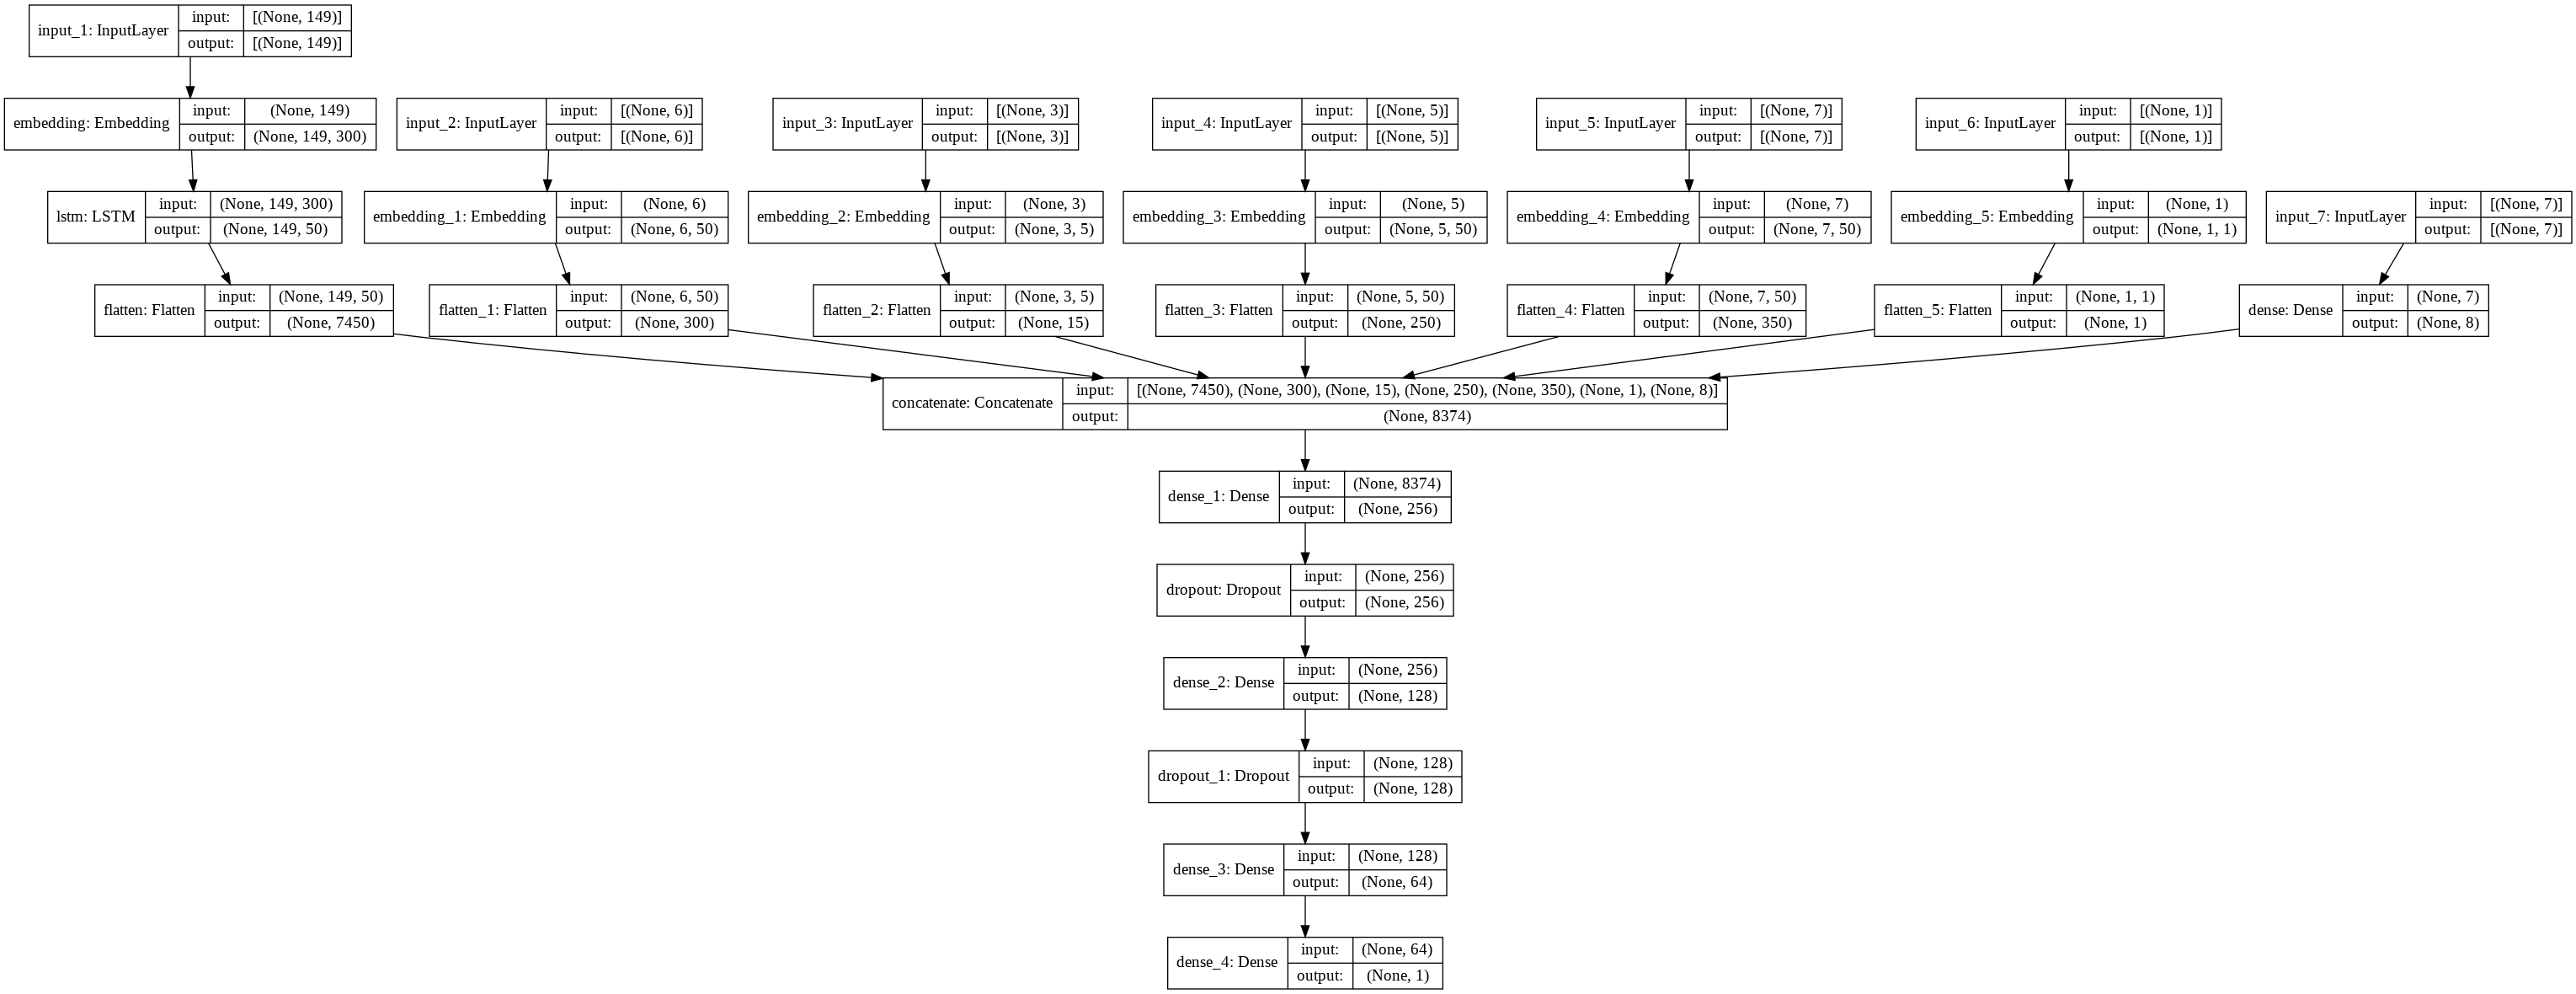

In [49]:
#Plot graph 
tf.keras.utils.plot_model(
    model, to_file= path + '/DLmodel1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

#### DEFINING THE METRIC RMSLE

In [ ]:
def rmsle_score(y_true, y_pred):
  return np.sqrt(msle(y_true,y_pred))

In [ ]:
def rmsle(y_true, y_pred):
  return tf.py_function(rmsle_score,(y_true,y_pred), tf.double)

In [ ]:
# Defining the function auc

#def auc(y_true,y_pred):
#    return tf.py_function(auc_score,(y_true,y_pred), tf.double)

#### CALLBACKS

In [ ]:
import os

if not os.path.isdir(path+"/DLModel_1"):
  os.mkdir(path+"/DLModel_1")

In [ ]:
callback_list = [
      tf.keras.callbacks.ModelCheckpoint(path + '/DLModel_1/best_model.h5', save_weights_only=True, save_best_only=True, monitor = 'val_rmsle', mode = 'min', verbose = 1),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_rmsle',mode='min',patience=2,verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_rmsle',mode='min',patience=5,verbose=1)
                 ]

#### PREPARING THE INPUTS

In [ ]:
X_tr_inp = [np.array(input_item_desc_train_padded_sequences),np.array(input_brand_train_padded_sequences),
                np.array(input_gencat_train_padded_sequences),np.array(input_subcat1_train_padded_sequences),
                np.array(input_subcat2_train_padded_sequences),np.array(input_brcat_train_padded_sequences),
                numerical_features_train_scaled]

X_te_inp = [np.array(input_item_desc_test_padded_sequences),np.array(input_brand_test_padded_sequences),
                np.array(input_gencat_test_padded_sequences),np.array(input_subcat1_test_padded_sequences),
                np.array(input_subcat2_test_padded_sequences),np.array(input_brcat_test_padded_sequences),
                numerical_features_test_scaled]

#### COMPILING AND FITTING THE MODEL

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.MeanSquaredLogarithmicError(), metrics = [rmsle])

In [ ]:
batch_length = 128

In [ ]:
history = model.fit(X_tr_inp, Y_train, batch_size=batch_length, epochs=20, validation_data=(X_te_inp,Y_test),callbacks=callback_list)

Epoch 1/20
8687/8687 [==============================] - 209s 23ms/step - loss: 0.6144 - rmsle: 0.7724 - val_loss: 0.7745 - val_rmsle: 0.8773

Epoch 00001: val_rmsle improved from inf to 0.87730, saving model to /content/drive/MyDrive/Self_Case_Study_1/DLModel_1/best_model.h5
Epoch 2/20
8687/8687 [==============================] - 201s 23ms/step - loss: 0.5682 - rmsle: 0.7515 - val_loss: 0.8650 - val_rmsle: 0.9274

Epoch 00002: val_rmsle did not improve from 0.87730
Epoch 3/20
8687/8687 [==============================] - 197s 23ms/step - loss: 0.5625 - rmsle: 0.7478 - val_loss: 0.5836 - val_rmsle: 0.7614

Epoch 00003: val_rmsle improved from 0.87730 to 0.76138, saving model to /content/drive/MyDrive/Self_Case_Study_1/DLModel_1/best_model.h5
Epoch 4/20
8687/8687 [==============================] - 203s 23ms/step - loss: 0.5570 - rmsle: 0.7441 - val_loss: 0.5664 - val_rmsle: 0.7502

Epoch 00004: val_rmsle improved from 0.76138 to 0.75021, saving model to /content/drive/MyDrive/Self_Case_St

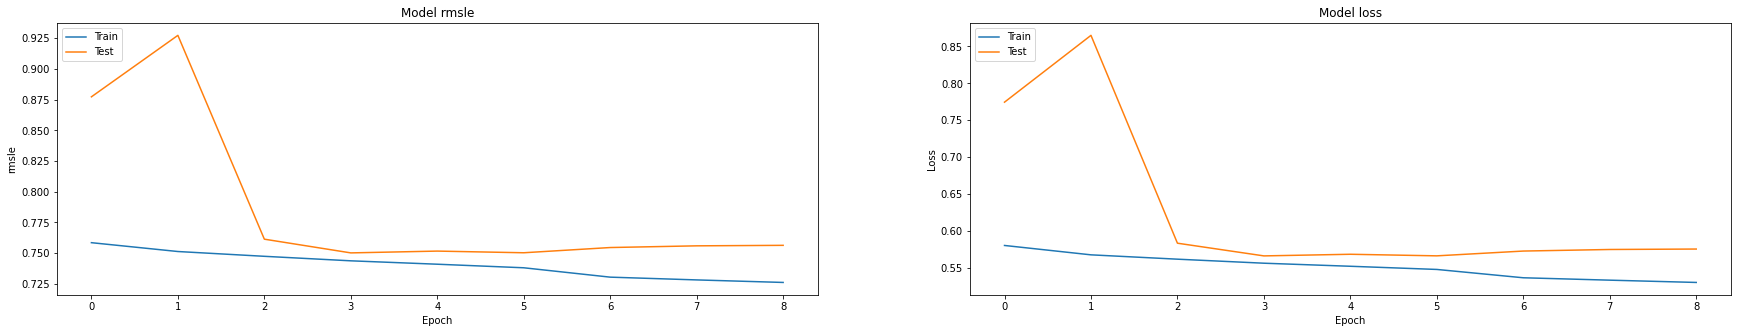

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['rmsle'])
plt.plot(history.history['val_rmsle'])
plt.title('Model rmsle')
plt.ylabel('rmsle')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# LOADING THE BEST SAVED MODEL

model.load_weights(path + '/DLModel_1/best_model.h5')

In [ ]:
loss, rmsle = model.evaluate(X_te_inp,Y_test)

print("Test loss for the best model is : {}".format(loss))
print("Test rmsle for the best model is : {}".format(rmsle))

11583/11583 [==============================] - 84s 7ms/step - loss: 0.5664 - rmsle: 0.7432
Test loss for the best model is : 0.566350519657135
Test rmsle for the best model is : 0.7432401776313782


In [ ]:
y_pred = model.predict(X_te_inp)

In [ ]:
y_pred[0:5]

array([[18.460085],
       [17.53003 ],
       [17.624838],
       [17.111467],
       [17.916859]], dtype=float32)

In [ ]:
type(y_pred)

numpy.ndarray

#### FEATURIZING THE UNSEEN TEST DATA AND PREDICTING THAT

#### LOADING THE TEST DATA WITH BRAND CATEGORY

In [50]:
test_data = pd.read_csv(path + "/test_data_with_brand_categories.csv")

In [51]:
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,item_description_Length,preprocessed_item_desc,neg,neu,pos,compound,category
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,No Brand Name,1,Size 7,Women,Jewelry,Rings,1,size,0.000,1.000,0.000,0.0000,affordable
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,No Brand Name,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,26,pcs new kraft bubble mailers lined bubble wrap...,0.000,0.703,0.297,0.8750,affordable
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,5,brand new coach bag bought coach outlet,0.000,1.000,0.000,0.0000,expensive
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,No Brand Name,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,7,floral kimono never worn lightweight perfect h...,0.275,0.551,0.173,-0.2755,affordable
4,4,Life after Death,3,Other/Books/Religion & Spirituality,No Brand Name,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,16,rediscovering life loss loved one tony cooke p...,0.309,0.362,0.329,0.1531,affordable


#### CONVERTING THE TEST DATA INTO PADDED SEQUENCE

In [52]:
del mercari_preprocessed_data
del X
del Y

In [53]:
unseen_test_item_desc_list = []
for text in list(test_data["preprocessed_item_desc"]):
    if isinstance(text,float):
        text = str(text)
        unseen_test_item_desc_list.append(text)
    else:
        unseen_test_item_desc_list.append(text)

In [54]:
# Converting the preprocessed_item_description into padded sequences
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_item_desc = 149

# Tokenizing the training data and fitting the tokenizer on the training data
#Tokenizer_item_desc_unseen_test = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token = oov_token)# 
#Tokenizer_item_desc_unseen_test.fit_on_texts(unseen_test_item_desc_list)


input_item_desc_unseen_test_sequences = Tokenizer_item_desc.texts_to_sequences(unseen_test_item_desc_list)# Encoding test data sentences into sequences
input_item_desc_unseen_test_padded_sequences = pad_sequences(input_item_desc_unseen_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_item_desc) # Padding the sequences in training data


In [55]:
# Converting the brand_name into padded sequences
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_brand = 6

# Tokenizing the training data and fitting the tokenizer on the training data
#Tokenizer_brand_unseen_test = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
#Tokenizer_brand_unseen_test.fit_on_texts(test_data.brand_name.values)

input_brand_unseen_test_sequences = Tokenizer_brand.texts_to_sequences(test_data.brand_name.values)# Encoding test data sentences into sequences
input_brand_unseen_test_padded_sequences = pad_sequences(input_brand_unseen_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_brand) # Padding the sequences in training data


In [56]:
np.save(path + "/DLModel_1/input_sequence_preprocessed_item_desc.npy", input_item_desc_unseen_test_padded_sequences)
np.save(path + "/DLModel_1/input_sequence_brand.npy", input_brand_unseen_test_padded_sequences)

In [57]:
# Converting the general_cat into padded sequences
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_gen_cat = 3

# Tokenizing the training data and fitting the tokenizer on the training data
#Tokenizer_gen_cat_unseen_test = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
#Tokenizer_gen_cat_unseen_test.fit_on_texts(test_data.general_cat.values)

input_gencat_unseen_test_sequences = Tokenizer_gen_cat.texts_to_sequences(test_data.general_cat.values)# Encoding test data sentences into sequences
input_gencat_unseen_test_sequences = pad_sequences(input_gencat_unseen_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_gen_cat) # Padding the sequences in training data

In [58]:
# Converting the subcat_1 into padded sequences
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_subcat_1 = 5

# Tokenizing the training data and fitting the tokenizer on the training data
#Tokenizer_subcat_1_unseen_test = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
#Tokenizer_subcat_1_unseen_test.fit_on_texts(test_data.subcat_1.values)

input_subcat1_unseen_test_sequences = Tokenizer_subcat_1.texts_to_sequences(test_data.subcat_1.values)# Encoding test data sentences into sequences
input_subcat1_unseen_test_padded_sequences = pad_sequences(input_subcat1_unseen_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_subcat_1) # Padding the sequences in training data

In [59]:
np.save(path + "/DLModel_1/input_sequence_gencat.npy", input_gencat_unseen_test_sequences)
np.save(path + "/DLModel_1/input_sequence_subcat1.npy", input_subcat1_unseen_test_padded_sequences)

In [61]:
# Converting the subcat_2 into padded sequences
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_subcat_2 = 7

# Tokenizing the training data and fitting the tokenizer on the training data
#Tokenizer_subcat_2_unseen_test = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
#Tokenizer_subcat_2_unseen_test.fit_on_texts(test_data.subcat_2.v#alues)

input_subcat2_unseen_test_sequences = Tokenizer_subcat_2.texts_to_sequences(test_data.subcat_2.values)# Encoding test data sentences into sequences
input_subcat2_unseen_test_padded_sequences = pad_sequences(input_subcat2_unseen_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_subcat_2) # Padding the sequences in training data

In [62]:
oov_token = 'OOV'
pad_type = 'post'
trunc_type = 'post'
maxlen_br_category = 1

# Tokenizing the training data and fitting the tokenizer on the training data
#Tokenizer_br_cat_unseen_test = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token = oov_token)# 
#Tokenizer_br_cat_unseen_test.fit_on_texts(test_data.category.values)

input_brcat_unseen_test_sequences = Tokenizer_br_cat.texts_to_sequences(test_data.category.values)# Encoding test data sentences into sequences
input_brcat_unseen_test_padded_sequences = pad_sequences(input_brcat_unseen_test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen_br_category) # Padding the sequences in training data

In [63]:
np.save(path + "/DLModel_1/input_sequence_subcat2.npy",input_subcat2_unseen_test_padded_sequences)
np.save(path + "/DLModel_1/input_sequence_brand_cat.npy",input_brcat_unseen_test_padded_sequences)

In [64]:
# Subsetting the numerical features in the test data

numerical_features_unseen_test = test_data.loc[:,['item_condition_id', 'shipping', 'item_description_Length','neg','pos','neu','compound']]

In [65]:
#from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_features_unseen_test_scaled = scaler.transform(numerical_features_unseen_test.values)

In [67]:
np.save(path + "/DLModel_1/numerical_scaled_features.npy",numerical_features_unseen_test_scaled)

In [38]:
input_item_desc_unseen_test_padded_sequences = np.load(path + '/DLModel_1/input_sequence_preprocessed_item_desc.npy')
input_brand_unseen_test_padded_sequences = np.load(path + '/DLModel_1/input_sequence_brand.npy')
input_gencat_unseen_test_sequences = np.load(path + '/DLModel_1/input_sequence_gencat.npy')
input_subcat1_unseen_test_padded_sequences = np.load(path + '/DLModel_1/input_sequence_subcat1.npy')
input_subcat2_unseen_test_padded_sequences = np.load(path + '/DLModel_1/input_sequence_subcat2.npy')
input_brcat_unseen_test_padded_sequences = np.load(path + '/DLModel_1/input_sequence_brand_cat.npy')
numerical_features_unseen_test_scaled = np.load(path + "/DLModel_1/numerical_scaled_features.npy")

In [53]:
del test_data

In [39]:
unseen_te_inp = [np.array(input_item_desc_unseen_test_padded_sequences),np.array(input_brand_unseen_test_padded_sequences),
                np.array(input_gencat_unseen_test_sequences),np.array(input_subcat1_unseen_test_padded_sequences),
                np.array(input_subcat2_unseen_test_padded_sequences),np.array(input_brcat_unseen_test_padded_sequences),
                numerical_features_unseen_test_scaled]


#### LOADING THE BEST MODEL AND PREDICTING ON THE UNSEEN TEST DATA

In [40]:
model.load_weights(path + "/DLModel_1/best_model.h5")

In [41]:
Y_DL_predict = model.predict(unseen_te_inp)

In [42]:
Y_DL_predict[0:5]

array([[17.357204],
       [21.34284 ],
       [18.035398],
       [17.407286],
       [18.20546 ]], dtype=float32)

In [43]:
predictions_dl = pd.DataFrame(Y_DL_predict, columns = ['price'])

In [44]:
predictions_dl.head()

,price
0,17.357204
1,21.342840
2,18.035398
3,17.407286
4,18.205460


In [45]:
predictions_dl.reset_index(inplace=True)

In [46]:
predictions_dl.head()

,index,price
0,0,17.357204
1,1,21.342840
2,2,18.035398
3,3,17.407286
4,4,18.205460


In [47]:
predictions_dl.columns = ['test_id','price']

In [48]:
predictions_dl.shape

(3460725, 2)

In [49]:
# Saving the file to the disk
predictions_dl.to_csv(path + "/predictions_dl.csv",index=False)

#### KAGGLE SCREENSHOT:-

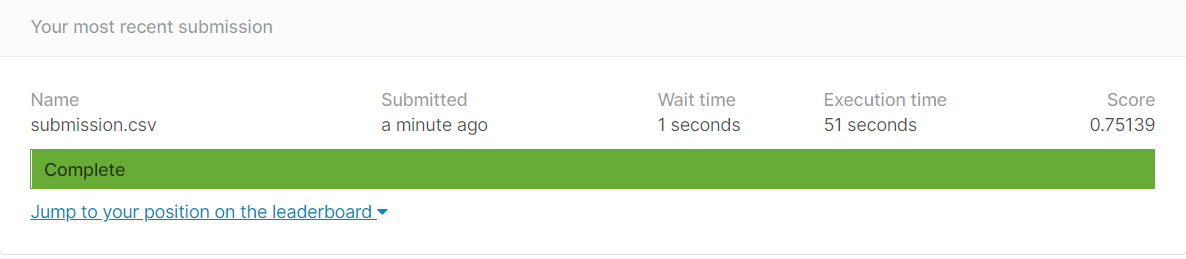

#### OBSERVATION:-

1) The Deep Learning model resulted in an incremental improvement on XGBoost Regressor. However, as per the results from Kaggle, it is the best one at 0.7514 approximately.